In [570]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import patsy
import scipy as sp
import seaborn as sns
from statsmodels import api as sm

df = pd.read_csv('http://www.stat.cmu.edu/~larry/all-of-nonpar/=data/lidar.dat',
                 sep=' *', engine='python')
df['std_range'] = (df.range - df.range.min()) / df.range.ptp()

n = df.shape[0]

df.head()

,range,logratio,std_range
0,390,-0.050356,0.000000
1,391,-0.060097,0.003030
2,393,-0.041901,0.009091
3,394,-0.050985,0.012121
4,396,-0.059913,0.018182


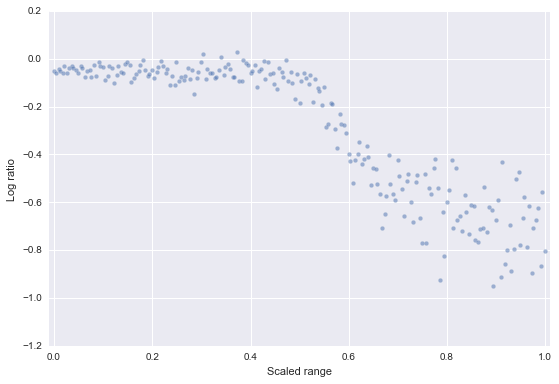

In [571]:
fig, ax = plt.subplots(figsize=(8, 6))

blue = sns.color_palette()[0]
ax.scatter(df.std_range, df.logratio, c=blue, alpha=0.5);

ax.set_xlim(-0.01, 1.01);
ax.set_xlabel('Scaled range');

ax.set_ylabel('Log ratio');

In [572]:
def R(x, z):
    return ((z - 0.5)**2 - 1 / 12) * ((x - 0.5)**2 - 1 / 12) / 4 - ((np.abs(x - z) - 0.5)**4 - 0.5 * (np.abs(x - z) - 0.5)**2 + 7 / 240) / 24

R = np.frompyfunc(R, 2, 1)

def R_(x):
    return R.outer(x, knots).astype(np.float64)

In [573]:
q = 20

knots = df.std_range.quantile(np.linspace(0, 1, q))

In [574]:
y, X = patsy.dmatrices('logratio ~ std_range + R_(std_range)', data=df)

In [575]:
S = np.zeros((q + 2, q + 2))
S[2:, 2:] = R_(knots)

In [576]:
B = np.zeros_like(S)
B[2:, 2:] = np.real_if_close(sp.linalg.sqrtm(S[2:, 2:]), tol=10**8)

In [577]:
def fit(y, X, B, lambda_=1.0):
    # build the augmented matrices
    y_ = np.vstack((y, np.zeros((q + 2, 1))))
    X_ = np.vstack((X, np.sqrt(lambda_) * B))
    
    return sm.OLS(y_, X_).fit()

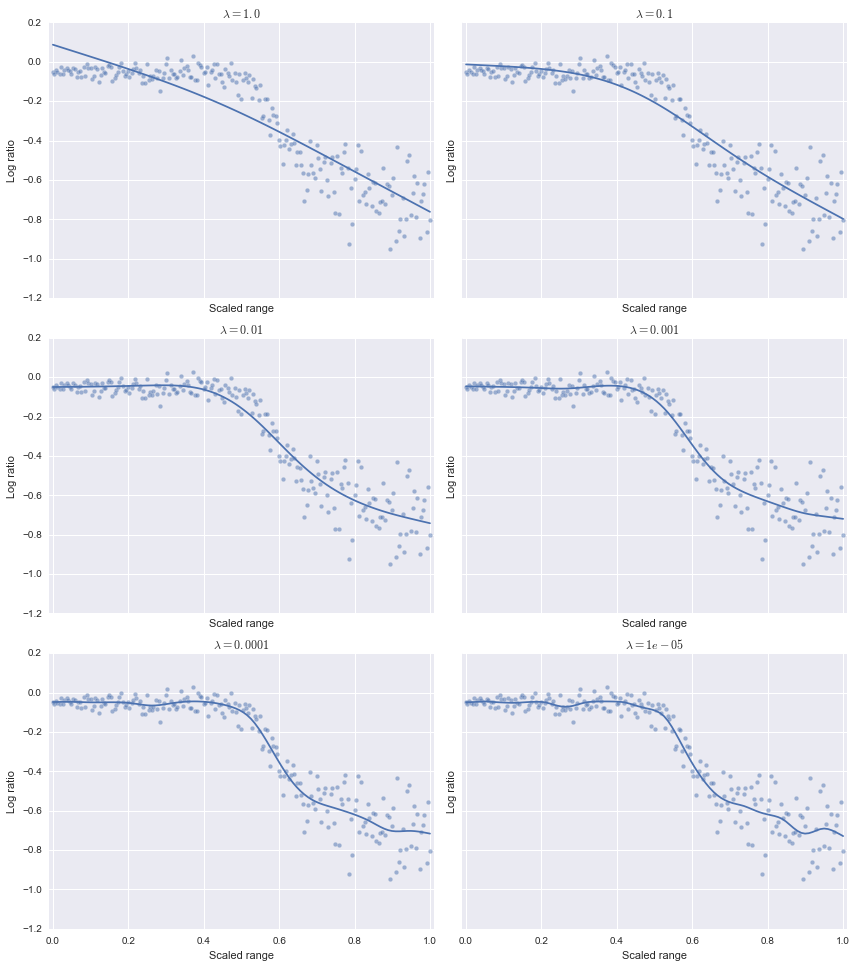

In [578]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, squeeze=True, figsize=(12, 13.5))

plot_lambdas = np.array([1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001])

plot_x = np.linspace(0, 1, 100)
plot_X = patsy.dmatrix('std_range + R_(std_range)', {'std_range': plot_x})

for lambda_, ax in zip(plot_lambdas, np.ravel(axes)):
    ax.scatter(df.std_range, df.logratio, c=blue, alpha=0.5);
    
    results = fit(y, X, B, lambda_=lambda_)
    ax.plot(plot_x, results.predict(plot_X));
    
    ax.set_xlim(-0.01, 1.01);
    ax.set_xlabel('Scaled range');
    
    ax.set_ylabel('Log ratio');
    
    ax.set_title(r'$\lambda = {}$'.format(lambda_));

fig.tight_layout();

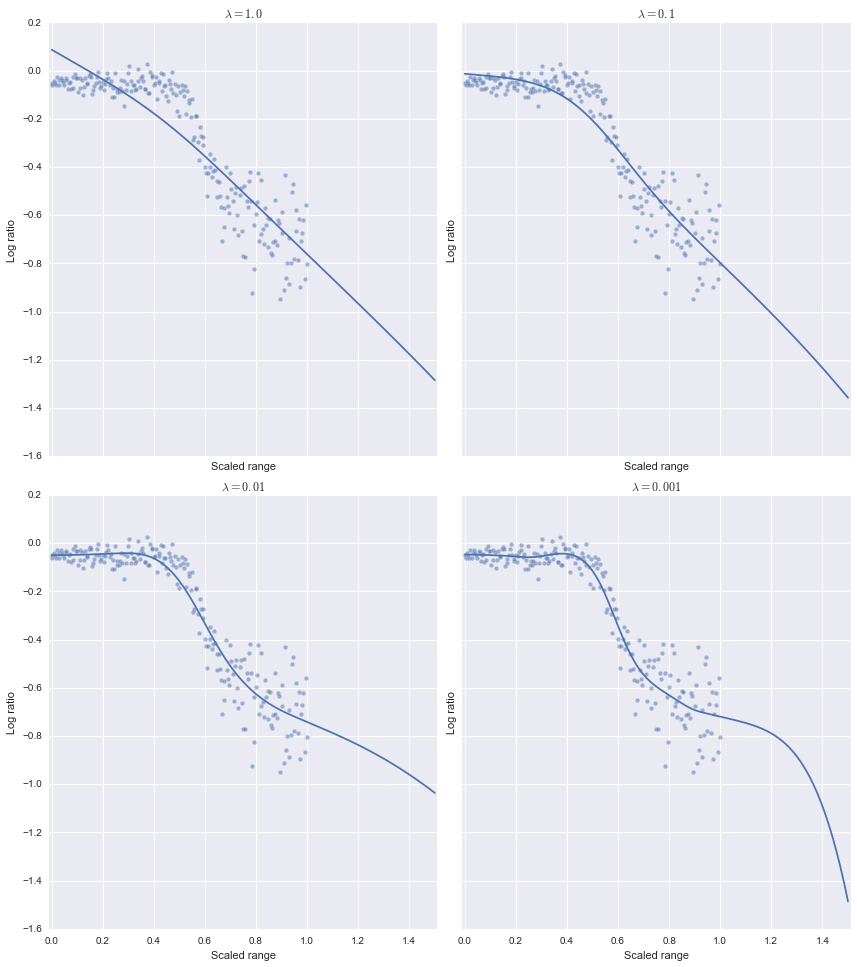

In [579]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, squeeze=True, figsize=(12, 13.5))

plot_lambdas = np.array([1.0, 0.1, 0.01, 0.001])

plot_x = np.linspace(0, 1.5, 100)
plot_X = patsy.dmatrix('std_range + R_(std_range)', {'std_range': plot_x})

for lambda_, ax in zip(plot_lambdas, np.ravel(axes)):
    ax.scatter(df.std_range, df.logratio, c=blue, alpha=0.5);
    
    results = fit(y, X, B, lambda_=lambda_)
    ax.plot(plot_x, results.predict(plot_X));
    
    ax.set_xlim(-0.01, 1.51);
    ax.set_xlabel('Scaled range');
    
    ax.set_ylabel('Log ratio');
    
    ax.set_title(r'$\lambda = {}$'.format(lambda_));

fig.tight_layout();

In [580]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date, time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math
from matplotlib import dates

%matplotlib inline
#This is graph line style, from Nate silver
plt.style.use('fivethirtyeight')

#This is for the interactive plotting using bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.models.markers import Asterisk
from bokeh.models import ColumnDataSource, DataRange1d, Plot, LinearAxis, Grid
from bokeh.models import HoverTool

#My mac directory path
#_DATA_DIR = r'/Users/schem001/Desktop/Diabetes Project/Diabetic-Project/input'
#_FIG_DIR = r'/Users/schem001/Desktop/Diabetes Project/Diabetic-Project/figures'

#My win directory path
_DATA_DIR = r'C:\Users\engadmin\Desktop\Diabetes  Project Code\Input\input'
_FIG_DIR = r'C:\Users\engadmin\Desktop\Diabetes  Project Code\figures'

if not os.path.exists(_FIG_DIR):
    os.makedirs(_FIG_DIR)
    
_GULCOSE_DATA_PATH = os.path.join(_DATA_DIR, 'P5.csv')
fields = ["Date", "mg/dL", "CHO (g)", "Fat (g)", "Protein (g)"]
df_P = pd.read_csv(_GULCOSE_DATA_PATH, parse_dates=['Date'], usecols = fields) #read and prase Date col as dataTimes object
df_P = df_P.sort_values(['Date'])

## Matplotlib Variables
_FIG_SIZE = (14, 6)
_FIG_FORMAT = 'png'
_FIG_DPI = 200

def _file_format(string_):
    string_ = string_.replace('-', '_').replace(' ', '_').replace('$', '')
    string_ += '.' + _FIG_FORMAT
    return string_

#For printing full elements of dataframe or array
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
pre_recording_mins = 15 #Minutes that may have elapsed before patient has recorded the reading
gl_increase = 20 #15mg/dL increase because we are interested in meals for now, later we can include sncaks
gl_decrease = 20 #15mg/dl of glucose drop (we noticed from the data that 10mg/dl would be too low and may result in not finding the highest peak after meal)

In [581]:
#Task 1

#print "\nTotal number of glucose readings for this patient is:", df_P['mg/dL'].size
#print "\nRecordings inbetween may be missing, the above number represents the collected readings from start date to end date."

#Removing NaN from a specific column of the dataframe, here it's mg/dL
df_P_wonan_mg = df_P.dropna(subset=['mg/dL'])
#print "\nRemove NaN from the mg/dL column...\n"
print("\nTotal number of glucose readings is:", df_P_wonan_mg['mg/dL'].size)

#Converting object type to float for all of the dataframe (df_Pv2 stands for dataframe, patient, version 2)
df_Pv2= pd.DataFrame(df_P_wonan_mg).convert_objects(convert_numeric=True)

#Task 2
print("\n-------------------------------------------")
#Get Meal dataframe

#print "\nRemove NaN from the CHO so we can plot the points of meals..."
df_Pv2 = df_Pv2.dropna(subset=['CHO (g)'])
#print "\nNumber of meals recorded is:", df_Pv2['CHO (g)'].size
#print "\nSome of the successive meal readings stand for one meal with many servings."

df_Pv2 = df_Pv2.reset_index(drop=True)

df_P_meals = copy.deepcopy(df_Pv2)

print('\nCombine succesive meal readings (CHO, fat, protein), occuring within a 30 minute window,...') 

#Task 3
row = 0
i = 0   
while (i < (df_Pv2['CHO (g)'].size-1)):
    k = i
    row = row + 1         
   
    minutesdiff = df_Pv2.Date[k+1] - df_Pv2.Date[k]
    
    #If the meals are within 30 minutes of each other, combine into one
    while ((minutesdiff.seconds / 60 <= 30)):
        #drop this row but add CHO and fats and proteins to values of previous row
        k = k+1
        df_P_meals.set_value(row-1,'CHO (g)',df_P_meals['CHO (g)'][row-1]+df_P_meals['CHO (g)'][row])
        df_P_meals.set_value(row-1,'Fat (g)',df_P_meals['Fat (g)'][row-1]+df_P_meals['Fat (g)'][row])
        df_P_meals.set_value(row-1,'Protein (g)',df_P_meals['Protein (g)'][row-1]+df_P_meals['Protein (g)'][row])
        df_P_meals.drop(df_P_meals.index[row], axis=0, inplace=True)
        df_P_meals = df_P_meals.reset_index(drop=True)
        if (k == (df_Pv2['CHO (g)'].size-1)):
            break   
        minutesdiff = df_Pv2.Date[k+1] - df_Pv2.Date[k]
    i = k+1               

df_P_meals = df_P_meals.reset_index(drop=True)
print("\n\nTotal of", df_P_meals['CHO (g)'].size, "recorded meals.\n") 

print("\nA sample (head) of the meals dataframe...\n\n", df_P_meals.head())

# plt.figure(figsize=_FIG_SIZE)
# plt.plot_date(df_P.Date, df_P['mg/dL'], '-', label="Glucose Level");
# plt.plot_date(df_P_meals.Date, df_P_meals['mg/dL'], 'ro', label="Meal Time")
# plt.xlabel('Date (Day-Month)')
# plt.ylabel('Glucose Reading (mg/dl)')
# plt.legend(loc='upper right')
# title = ''
# ax=plt.gca()
# xfmt = dates.DateFormatter('%d-%m')
# #xfmt = dates.DateFormatter('%d-%m-%y %H:%M')
# ax.xaxis.set_major_formatter(xfmt)

# plt.title(title);

#For later use, maybe
#Last non empty row of patient data
nonempty_P_readings = df_P[pd.notnull(df_P['Date'])]
nonempty_readings = df_P[pd.notnull(df_P['Date'])]
last_row_date = nonempty_readings.iloc[-1, nonempty_readings.columns.get_loc('Date')]


print("BG average for this patient is:", np.mean(df_P_wonan_mg['mg/dL']), "with a std of", np.std(df_P_wonan_mg['mg/dL']))

print(df_P.iloc[140:,])


Total number of glucose readings is: 7676

-------------------------------------------

Combine succesive meal readings (CHO, fat, protein), occuring within a 30 minute window,...


Total of 171 recorded meals.


A sample (head) of the meals dataframe...

                  Date  mg/dL  CHO (g)  Fat (g)  Protein (g)
0 2008-08-04 17:41:00  126.0    92.26    23.83        14.78
1 2008-08-05 05:31:00  126.0   194.72    11.59        35.83
2 2008-08-05 07:01:00  103.0     0.00     0.05         0.28
3 2008-08-05 09:56:00  108.0    26.95     0.39         1.29
4 2008-08-05 12:21:00  105.0    70.24     0.61        12.37
BG average for this patient is: 114.970557582074 with a std of 22.015300195096987
                    Date  mg/dL  CHO (g) Fat (g) Protein (g)
141  2008-08-05 03:56:00   71.0      NaN     NaN         NaN
142  2008-08-05 04:01:00   65.0      NaN     NaN         NaN
143  2008-08-05 04:06:00   67.0      NaN     NaN         NaN
144  2008-08-05 04:11:00   68.0      NaN     NaN        

In [582]:
print("\n-------------Condition 1-------------------")
print("\nRemove meal data points with several missing BG readings in their postprandial window...\n")

#This chunk of code implements the first condition, which removes the meals that have significant missing successive points
import datetime

df_P_meals_w_deletion = copy.deepcopy(df_P_meals)

#variables
incr = 5 #Data was recorded at 5 minutes increments
#window_size = 23 #This represents window size based on increments of 5.

window_size_minutes = 90# in minutes
window_size = (window_size_minutes / 5) - 1

del_points_df_a = pd.DataFrame()#Dataframe containing meal to be deleted by this assumption
points_to_del_a = []

for x in range(df_P_meals_w_deletion['CHO (g)'].size):
    a = df_P_meals_w_deletion['Date'][x]
    b = a
    count = 0
    for j in range(int(window_size)):
        b += datetime.timedelta(minutes=incr)
        reading = df_P.loc[df_P['Date'] == b]['mg/dL']
        try:
            reading.values[0]
        except IndexError:
            #print "Index out of range"
            count +=1 
            continue  
        if (math.isnan(reading.values[0])):
            count +=1
    #If eight of the window size has missing values, exclude that meal
    if (count > ((window_size+1)/8)):
        print("\nThe meal at", a, "has", count,"missing readings within its following {}".format((window_size+1)*5),"minutes. Thus, it will be removed.")
        #Put this into a dataframe to plot later with different color
        del_points_df_a = del_points_df_a.append(df_P.loc[df_P['Date'] == a])        
        points_to_del_a.extend([x])  

#Remove the above detected points from dataset
df_P_meals_w_deletion.drop(df_P_meals_w_deletion.index[points_to_del_a],axis=0,inplace=True)
df_P_meals_w_deletion = df_P_meals_w_deletion.sort_values(['Date'])
df_P_meals_w_deletion = df_P_meals_w_deletion.reset_index(drop=True)

if (df_P_meals_w_deletion['CHO (g)'].size == df_P_meals['CHO (g)'].size):
    print("There are no meals that need to be excluded, at this stage.\n")

print("\nThere are", df_P_meals_w_deletion['CHO (g)'].size, "remaining meal recordings.\n") 


-------------Condition 1-------------------

Remove meal data points with several missing BG readings in their postprandial window...


The meal at 2008-08-07 15:26:00 has 10 missing readings within its following 90.0 minutes. Thus, it will be removed.

The meal at 2008-08-15 17:21:00 has 6 missing readings within its following 90.0 minutes. Thus, it will be removed.

The meal at 2008-08-16 18:21:00 has 13 missing readings within its following 90.0 minutes. Thus, it will be removed.

The meal at 2008-08-18 06:16:00 has 14 missing readings within its following 90.0 minutes. Thus, it will be removed.

The meal at 2008-08-28 18:01:00 has 7 missing readings within its following 90.0 minutes. Thus, it will be removed.

The meal at 2008-08-31 18:11:00 has 4 missing readings within its following 90.0 minutes. Thus, it will be removed.

There are 165 remaining meal recordings.



In [583]:
print("\n-------------Condition 2-------------------")

#This chunk of code implements the second constraint, removing meals which do not have a significant postprandial glucose increase
df_P_meals_w_deletion_b = copy.deepcopy(df_P_meals_w_deletion)

incr = 5 #Data was collected at 5 minutes increments- Do not change this
glucose_effect_window = 45 #Minutes food may take to be reflected on the blood glucose
#Change below to higher minutes if glucose increases slowly
gl_increase_window = 45 #Minutes from the instance where the glucose is reflected on the blood to significant increase


print("\nRemove meal data points which do NOT have significant BG INCREASE, at least",gl_increase,"mg/dl, in their postprandial window...\n")


#May want to change VARIABLES above for different patients, especially if food takes a while to affect their glucose level

meal_affect_window = [i for i in np.arange(-(pre_recording_mins), glucose_effect_window+incr+incr, incr)] #glucose_effect_window+incr+incr, so we account from 0mins to 45mins included

compare_window = [j for j in np.arange(incr, gl_increase_window+incr, incr)]

points_to_del_b = []
del_points_df_b = pd.DataFrame()#Dataframe containing meal to be deleted by this assumption
low_surrounding_gl = pd.DataFrame()#Dataframe containing points where the glucose will go to take a significant increase, not necessarily the very lowest points
high_surrounding_gl = pd.DataFrame()
offset_low_point_to_meal = []

for x, item in enumerate(df_P_meals_w_deletion_b['Date']):
    
    a = df_P_meals_w_deletion_b['Date'][x]
    meal_reading = df_P.loc[df_P['Date'] == item]['mg/dL']
    b = item - datetime.timedelta(minutes=pre_recording_mins) 
    keep = 0
    
    for i in meal_affect_window:
        
        if (i == meal_affect_window[-1]):
        #print "The meal reading taken at" ,a, "should be deleted."            
        #print "The reading that is about to be removed has the following size, CHO", round(df_P_meals_w_deletion_b['CHO (g)'][x],2),"g, Proteins", round(df_P_meals_w_deletion_b['Protein (g)'][x],2),"g, Fats", round(df_P_meals_w_deletion_b['Fat (g)'][x],2),"g"

            #Put this into an dataframe to plot with different color
            del_points_df_b = del_points_df_b.append(df_P.loc[df_P['Date'] == item])
            #Also remove this from dataset   
            points_to_del_b.extend([x])
            break
        
        current_reading = df_P.loc[df_P['Date'] == b]['mg/dL']
        try:
            current_reading.values[0]
        except IndexError:
            #print "Index out of range"
            b += datetime.timedelta(minutes=incr)   
            continue            
        if (math.isnan(current_reading.values[0])):
            b += datetime.timedelta(minutes=incr)  
            continue      
            
        c = b
        for k in compare_window:#comparing the point with its following readings in compare window size
            c += datetime.timedelta(minutes=incr)
            compare_reading = df_P.loc[df_P['Date'] == c]['mg/dL']
            if ((compare_reading.values[0] - current_reading.values[0]) >=gl_increase):
                #Store this reading on a dataframe of low readings surrounding meals
                low_surrounding_gl = low_surrounding_gl.append(df_P.loc[df_P['Date'] == b])
                high_surrounding_gl = high_surrounding_gl.append(df_P.loc[df_P['Date'] == c])
                #print "a is:", a, "and b is:", b, "and c is:", c, "and difference between b and c is:", (c - b)
                if (b<item):
                    offset_low_point_to_meal.extend([int(-(item-b).seconds / 60)])
                    #print "The time elapsed between original meal time and surrounding low point is:", "-", (a-b).seconds / 60 ,"minutes."        
                else:
                    offset_low_point_to_meal.extend([int((b-item).seconds / 60)])
                    #print "The time elapsed between original meal time and surrounding low point is:", "+", (b-a).seconds / 60 ,"minutes."  
                keep = 1  
                break
                
        if (keep == 1):
            break
        b += datetime.timedelta(minutes=incr)    
        
print("\n", len(points_to_del_b), "meal recordings are to be removed.")

df_P_meals_w_deletion_b.drop(df_P_meals_w_deletion_b.index[points_to_del_b],axis=0,inplace=True)
df_P_meals_w_deletion_b = df_P_meals_w_deletion_b.sort_values(['Date'])
df_P_meals_w_deletion_b = df_P_meals_w_deletion_b.reset_index(drop=True)

print("\nThere are", df_P_meals_w_deletion_b['CHO (g)'].size, "remaining meal time recordings.\n") 

low_surrounding_gl = low_surrounding_gl.sort_values(['Date'])
low_surrounding_gl = low_surrounding_gl.reset_index(drop=True)

high_surrounding_gl = high_surrounding_gl.sort_values(['Date'])
high_surrounding_gl = high_surrounding_gl.reset_index(drop=True)

df_P_meals_w_deletion_v2 = copy.deepcopy(df_P_meals_w_deletion_b)


-------------Condition 2-------------------

Remove meal data points which do NOT have significant BG INCREASE, at least 20 mg/dl, in their postprandial window...


 61 meal recordings are to be removed.

There are 104 remaining meal time recordings.



In [584]:
print("\n-------------Condition 3-------------------")

#Step 1


minutes2peak = 90#Minutes to reach the peak after highest surrounding point detected before
gl_decrease_window = 90 #Minutes it takes for a significant glucose decrease after meal, it may take long time for glucose to go down, few hours

print("\nRemove meal data points which do NOT have significant BG DECREASE, at least",gl_decrease,"mg/dl, following their postprandial peak...\n")

up2peak_window = [j for j in np.arange(0, minutes2peak+incr+incr, incr)]
compare_window = [j for j in np.arange(incr, gl_decrease_window+incr, incr)]

afterpeak_lowgl_df = pd.DataFrame()#This dataframe contains the points after the glucose drop following the peak
lowpoint_to_del_df = pd.DataFrame()#Dataframe contaning any meal recording to be deleted because they do not have a significant nearby glucose drop after the increase
peak_points_df = pd.DataFrame()#Dataframe containing peak points following meal times
lowpoint_to_del = []

for x, item in enumerate(high_surrounding_gl['mg/dL']):   
    a = high_surrounding_gl['Date'][x]   
    keep = 0
    b= a

    for i in up2peak_window:
        current_reading = df_P.loc[df_P['Date'] == b]['mg/dL']
        c = b

        if (i == up2peak_window[-1]):
            #print("Could not detect a significant glucose drop after this meal recording", df_P_meals_w_deletion_v2['Date'][x], ". It is suggested to delete it")  
            print("current reading is: ", current_reading, "at date", df_P.loc[df_P['Date'] == b])
            lowpoint_to_del.extend([x])  
            lowpoint_to_del_df = lowpoint_to_del_df.append(df_P.loc[df_P['Date'] == a])
            break
        
        for k in compare_window:#comparing the point with its following readings in compare window size
            c += datetime.timedelta(minutes=incr)
            compare_reading = df_P.loc[df_P['Date'] == c]['mg/dL']
            try:
                compare_reading.values[0]
            except IndexError:
                #print "Index out of range"
                continue   

            #print "current", current_reading.values[0]
            #print "compare", compare_reading.values[0]
            #if (~np.isnan(compare_reading.values[0])):
            if ((current_reading.values[0] - compare_reading.values[0]) >= gl_decrease) :#significant glucose drop has been detected
                #Store this reading on a dataframe of points detecting glucose drop after peak
                afterpeak_lowgl_df = afterpeak_lowgl_df.append(df_P.loc[df_P['Date'] == c])
                keep = 1
                break
            #else:
            #    continue
                
        if (keep == 1):
            break   
               
        b += datetime.timedelta(minutes=incr)    

afterpeak_lowgl_df = afterpeak_lowgl_df.reset_index(drop=True)
lowpoint_to_del_df = lowpoint_to_del_df.reset_index(drop=True)

condition3_df = copy.deepcopy(df_P_meals_w_deletion_v2)
condition3_index =[]
for k in range (df_P_meals_w_deletion_v2.shape[0]):
    if (k not in lowpoint_to_del):
        condition3_index.append(k)

print(len(lowpoint_to_del))
print(len(condition3_index))
condition3_df.drop(condition3_df.index[condition3_index],axis=0,inplace=True)  
condition3_df = condition3_df.reset_index(drop=True)

print(condition3_df.shape[0])

#step 3
#print "Could not detect a significant glucose drop after the following meal recordings:\n\n",lowpoint_to_del_df['Date']
#Drop x from the "all the meals" dataframe 
df_P_meals_w_deletion_v2.drop(df_P_meals_w_deletion_v2.index[lowpoint_to_del],axis=0,inplace=True)  
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.reset_index(drop=True)

low_surrounding_gl.drop(low_surrounding_gl.index[lowpoint_to_del],axis=0,inplace=True)  
low_surrounding_gl = low_surrounding_gl.reset_index(drop=True)

#print df_P_meals_w_deletion_v2


#Step 2

#print "\nThe dataframe of the points after detecting a glucose drop:\n", afterpeak_lowgl_df 
def drange(start, stop, step):
    while start <= stop:
            yield start
            start += step

#####This portion of the code is to detect the post-meal peak            
for x, item in enumerate(afterpeak_lowgl_df['mg/dL']):
    #print "At the meal of date", df_P1_meals_w_deletion['Date'][x], "the lowest point is at:", surrounding_lowest_points_df['Date'][x] , "and low after peak is at:", afterpeak_lowgl_df['Date'][x]  
    a = low_surrounding_gl['Date'][x]
    #print "x is:", x , "and its date is:", afterpeak_lowgl_df['Date'][x]   
    current_reading = df_P.loc[df_P['Date'] == a]['mg/dL'].values[0]
    lowpt_after_peak = afterpeak_lowgl_df['Date'][x]   
    b= a
    #difference in minutes between lowest point and the point after glucose drop following peak
    window_peak = (lowpt_after_peak-a).seconds / 60
    #print window_peak
    peak_index = 0

    for i in drange(5,window_peak,5):        
        b += datetime.timedelta(minutes=incr)
        if (b <= nonempty_P_readings.iloc[-1,nonempty_P_readings.columns.get_loc('Date')]):
            incrt_reading = df_P.loc[df_P['Date'] == b]['mg/dL'].values[0]   
            if (math.isnan(incrt_reading)):
                b += datetime.timedelta(minutes=incr)  
                continue

            if (incrt_reading > current_reading):
                current_reading = incrt_reading
                peak_index = i
    #print "the peak index is offseted by", peak_index, "minutes from the lowest reading"        
    c = a + datetime.timedelta(minutes=int(peak_index))
    
    peak_points_df = peak_points_df.append(df_P.loc[df_P['Date'] == c])

peak_points_df = peak_points_df.reset_index(drop=True)

print("\nThere are", df_P_meals_w_deletion_v2['Date'].size, "total remaining meal recordings.")


-------------Condition 3-------------------

Remove meal data points which do NOT have significant BG DECREASE, at least 20 mg/dl, following their postprandial peak...

current reading is:  1186    118.0
Name: mg/dL, dtype: float64 at date                     Date  mg/dL CHO (g) Fat (g) Protein (g)
1186 2008-08-08 19:01:00  118.0     NaN     NaN         NaN
current reading is:  1717    119.0
Name: mg/dL, dtype: float64 at date                     Date  mg/dL CHO (g) Fat (g) Protein (g)
1717 2008-08-10 15:16:00  119.0     NaN     NaN         NaN
current reading is:  2573    113.0
Name: mg/dL, dtype: float64 at date                     Date  mg/dL CHO (g) Fat (g) Protein (g)
2573 2008-08-13 14:36:00  113.0     NaN     NaN         NaN
current reading is:  3112    107.0
Name: mg/dL, dtype: float64 at date                     Date  mg/dL CHO (g) Fat (g) Protein (g)
3112 2008-08-15 11:31:00  107.0     NaN     NaN         NaN
current reading is:  3417    91.0
Name: mg/dL, dtype: float64 at d

In [585]:
#####This portion of the code is to detect lowest two points, and selects the closest one to the peak => this represents the bg increasing point         
increase_pt_date = []
lowest_1pts_series = []
lowest_2pts_series = []
for x, bg in enumerate(low_surrounding_gl['mg/dL']):
    a = low_surrounding_gl['Date'][x]
    current_reading = df_P.loc[df_P['Date'] == a]['mg/dL'].values[0]
    peak = peak_points_df['Date'][x]   
    b= a
    
    #difference in minutes between lowest point and the point after glucose drop following peak
    window = (peak-a).seconds / 60
    
    lowest_1pt = df_P.loc[df_P['Date'] == peak]['mg/dL'].values[0]#set to high value so it's overwritten
    lowest_2pt = df_P.loc[df_P['Date'] == peak]['mg/dL'].values[0]
    
    lowest_1pt_date = df_P.loc[df_P['Date'] == peak]['Date'].values[0]#set to high value so it's overwritten
    lowest_1pt_date = df_P.loc[df_P['Date'] == peak]['Date'].values[0]
    
    for i in drange(0,window,5): 
        #print "iteration", i, ", window size is:", window, "and current reading is at date:", b, "with peak date of:", peak
        current_bg = df_P.loc[df_P['Date'] == b]['mg/dL'].values[0]
        if ((current_bg <= lowest_1pt) and (current_bg < lowest_2pt)): 
            lowest_2pt = lowest_1pt
            lowest_2pt_date = lowest_1pt_date
            lowest_1pt = current_bg
            lowest_1pt_date = b
            

        elif(current_bg <= lowest_2pt):
            lowest_2pt = current_bg
            lowest_2pt_date = b
        
        b += datetime.timedelta(minutes=incr)
   
    peak_reading = peak_points_df['Date'][x]      
    
#     if (((peak_reading - lowest_1pt_date).seconds / 60)> ((peak_reading - lowest_2pt_date).seconds / 60)):
#         increase_pt_date.append(lowest_2pt_date)
#     else:
#         increase_pt_date.append(lowest_1pt_date) 
    
    lowest_1pts_series.append(lowest_1pt_date)
    lowest_2pts_series.append(lowest_2pt_date)
    
    minutesdiff = lowest_2pt_date - lowest_1pt_date
    #print "date difference is:", minutesdiff.seconds
    if (((minutesdiff.seconds)/60) > 10 and minutesdiff.days == 0):#if second point is closer to peak than first point
        increase_pt_date.append(lowest_2pt_date)
    else:
        increase_pt_date.append(lowest_1pt_date)


# print len(increase_pt_date) 
# print peak_points_df.shape[0]


# print increase_pt_date

In [586]:
print("\n-------------Extra-------------------\n")
print("For meal recordings having the same peak:\n", "\n   If meals are close to each other, remove the latest and keep the first.\n","\n   If meals are further from eachother, remove first and keep second.\n")

samepeak_meals_df = copy.deepcopy(df_P_meals_w_deletion_v2)
Samepeak_df = pd.DataFrame(columns=df_P_meals_w_deletion_v2.columns)
adjusted_increase_pts =[]
total_remove_pts = []
for k in range(2):


    remove_index = peak_points_df['Date'].size #setting this to some value it will never be so we can overwrite it later
    remove_pts = []




    print("k is ", k, "\n")
    for i in range(peak_points_df['Date'].size):
        if ((i < peak_points_df['Date'].size -1) and (peak_points_df['Date'][i] == peak_points_df['Date'][i+1]) and (i != remove_index) and (((df_P_meals_w_deletion_v2['Date'][i+1]- (df_P_meals_w_deletion_v2['Date'][i])).seconds / 60) <30)):            
            #print "\nThere are two BG increase starting points which have the same peak.", "The dates of the two readings are:", increase_pt_date[i], "and", increase_pt_date[(i+1)]
            #print "Their time difference is", (increase_pt_date[i+1]- increase_pt_date[i]).seconds/60, "minutes."

            #print "here1", df_P_meals_w_deletion_v2.iloc[i]
            Samepeak_df = Samepeak_df.append(df_P_meals_w_deletion_v2.iloc[i])  
            Samepeak_df = Samepeak_df.append(df_P_meals_w_deletion_v2.iloc[i+1])        
            print("first increment is for:\n", df_P_meals_w_deletion_v2.iloc[i])
            print("second increment is for:\n", df_P_meals_w_deletion_v2.iloc[i+1])
            total_mealCHO = df_P_meals_w_deletion_v2['CHO (g)'][i] + df_P_meals_w_deletion_v2['CHO (g)'][i+1]
            total_mealfat = df_P_meals_w_deletion_v2['Fat (g)'][i] + df_P_meals_w_deletion_v2['Fat (g)'][i+1]
            total_mealProtein = df_P_meals_w_deletion_v2['Protein (g)'][i] + df_P_meals_w_deletion_v2['Protein (g)'][i+1]

            df_P_meals_w_deletion_v2.set_value(i, 'CHO (g)', total_mealCHO)
            df_P_meals_w_deletion_v2.set_value(i, 'Fat (g)', total_mealfat)
            df_P_meals_w_deletion_v2.set_value(i, 'Protein (g)', total_mealProtein)

            #remove the first meal and keep the second with sum of both meal sizes
            remove_index = i+1
            remove_pts.append(remove_index)
            total_remove_pts.append(remove_index)
        elif ((i < peak_points_df['Date'].size -1) and (peak_points_df['Date'][i] == peak_points_df['Date'][i+1]) and (i != remove_index)):
            print("There are succesive meal readings which have the same peak but little far from each other, more than 30 minutes.", "Delete the first one:", increase_pt_date[i])
            #Samepeak_df.loc[-1] = df_P_meals_w_deletion_v2.iloc[i] 
            #print "here2", df_P_meals_w_deletion_v2.iloc[i]

            Samepeak_df = Samepeak_df.append(df_P_meals_w_deletion_v2.iloc[i])
            Samepeak_df = Samepeak_df.append(df_P_meals_w_deletion_v2.iloc[i+1])
            #Find lowest point between the two recorded meal times and set it as the new time increment
            diff = (df_P_meals_w_deletion_v2['Date'][i+1]  - df_P_meals_w_deletion_v2['Date'][i]).seconds/60
            #print "diff is:", diff 
            bg_date = df_P_meals_w_deletion_v2['Date'][i]
            temp_bg = df_P_meals_w_deletion_v2['mg/dL'][i]

            for k in drange(0,diff,5):
                current_bg = df_P.loc[df_P['Date'] == bg_date]['mg/dL'].values[0]
                if (current_bg <= temp_bg):
                    temp_bg = current_bg
                    increment = k

                bg_date += datetime.timedelta(minutes=incr)
                current_bg = df_P.loc[df_P['Date'] == bg_date]['mg/dL']
                try:
                    current_bg.values[0]
                except IndexError:
                    continue 

            #print "The increment for this one is :", increment

            new_bg_increase_date = df_P_meals_w_deletion_v2['Date'][i] + datetime.timedelta(minutes=increment)
            #print "The new date is:", new_bg_increase_date
            adjusted_increase_pts.append(new_bg_increase_date)


#             print "2nd: first increment is for:\n", df_P_meals_w_deletion_v2.iloc[i]
#             print "2nd: second increment is for:\n", df_P_meals_w_deletion_v2.iloc[i+1]
            remove_index = i
            remove_pts.append(remove_index)
            total_remove_pts.append(remove_index)
            total_mealCHO = df_P_meals_w_deletion_v2['CHO (g)'][i] + df_P_meals_w_deletion_v2['CHO (g)'][i+1]
            total_mealfat = df_P_meals_w_deletion_v2['Fat (g)'][i] + df_P_meals_w_deletion_v2['Fat (g)'][i+1]
            total_mealProtein = df_P_meals_w_deletion_v2['Protein (g)'][i] + df_P_meals_w_deletion_v2['Protein (g)'][i+1]

            df_P_meals_w_deletion_v2.set_value(i+1, 'CHO (g)', total_mealCHO)
            df_P_meals_w_deletion_v2.set_value(i+1, 'Fat (g)', total_mealfat)
            df_P_meals_w_deletion_v2.set_value(i+1, 'Protein (g)', total_mealProtein)

            remove_index = i+1

    print("same peak df is:", Samepeak_df)        

total_remove_pts= list(set(total_remove_pts))
    
    #remove the rows with the same peak points from all the dataframes, here we remove the first redundant rows
df_P_meals_w_deletion_v2.drop(df_P_meals_w_deletion_v2.index[total_remove_pts], axis=0,inplace=True)
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.sort_values(['Date'])
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.reset_index(drop=True)

#print "\nThere are ", df_P_meals_w_deletion_v2['Date'].size, "meals remaining.\n"

low_surrounding_gl.drop(low_surrounding_gl.index[total_remove_pts], axis=0,inplace=True)
low_surrounding_gl = low_surrounding_gl.sort_values(['Date'])
low_surrounding_gl = low_surrounding_gl.reset_index(drop=True)

#print "Length of increasing points:", len(increase_pts_v1)

peak_points_df.drop(peak_points_df.index[total_remove_pts], axis=0,inplace=True)
peak_points_df = peak_points_df.sort_values(['Date'])
peak_points_df = peak_points_df.reset_index(drop=True)

print("\nThere are ", df_P_meals_w_deletion_v2['Date'].size, "meals remaining.")


print(df_P_meals_w_deletion_v2)

Samepeak_df = Samepeak_df.sort_values(['Date'])
Samepeak_df = Samepeak_df.reset_index(drop=True)
print("same peak df is:", Samepeak_df) 




lowest_1pts_series_v1 = np.delete(lowest_1pts_series, total_remove_pts, axis=0)
lowest_2pts_series_v1 = np.delete(lowest_2pts_series, total_remove_pts, axis=0)
increase_pts_v1 = np.delete(increase_pt_date, total_remove_pts, axis=0)


-------------Extra-------------------

For meal recordings having the same peak:
 
   If meals are close to each other, remove the latest and keep the first.
 
   If meals are further from eachother, remove first and keep second.

k is  0 

There are succesive meal readings which have the same peak but little far from each other, more than 30 minutes. Delete the first one: 2008-08-05 13:51:00
There are succesive meal readings which have the same peak but little far from each other, more than 30 minutes. Delete the first one: 2008-08-05 19:56:00
There are succesive meal readings which have the same peak but little far from each other, more than 30 minutes. Delete the first one: 2008-08-06 10:21:00
There are succesive meal readings which have the same peak but little far from each other, more than 30 minutes. Delete the first one: 2008-08-07 04:46:00
There are succesive meal readings which have the same peak but little far from each other, more than 30 minutes. Delete the first one: 200

In [587]:
for k, item in enumerate(adjusted_increase_pts):
    for m, meal_date in enumerate(df_P_meals_w_deletion_v2['Date']):
        if (adjusted_increase_pts[k] <= df_P_meals_w_deletion_v2['Date'][m]):
            #print "adjusted is:", adjusted_increase_pts[k], "and meal date (i+1) is ", df_P_meals_w_deletion_v2['Date'][m]
            #print "old increase pt is:", increase_pts_v1[m], "new increase pt is:", adjusted_increase_pts[k]
            increase_pts_v1[m] = adjusted_increase_pts[k]
            break

In [588]:
#---------------Condition 4:---------------------
#Delete meals that have less than 30grams of carbs, as that is considered a snack rather than a meal
print("\n-------------Condition 4-------------------")
print("\nRemove meal with less than 20grams of Carbs...\n")

remove_pts_3 = []
for i in range(df_P_meals_w_deletion_v2['Date'].size):
    if (df_P_meals_w_deletion_v2['CHO (g)'][i] <20 and df_P_meals_w_deletion_v2['Protein (g)'][i] <5 and df_P_meals_w_deletion_v2['Fat (g)'][i] <5) :
        remove_index = i
        remove_pts_3.append(remove_index)

print("There are", len(remove_pts_3), "that contain less than 20g of Carbs.")

df_P_meals_w_deletion_v2.drop(df_P_meals_w_deletion_v2.index[remove_pts_3], axis=0,inplace=True)
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.sort_values(['Date'])
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.reset_index(drop=True)

low_surrounding_gl.drop(low_surrounding_gl.index[remove_pts_3], axis=0,inplace=True)
low_surrounding_gl = low_surrounding_gl.sort_values(['Date'])
low_surrounding_gl = low_surrounding_gl.reset_index(drop=True)

peak_points_df.drop(peak_points_df.index[remove_pts_3], axis=0,inplace=True)
peak_points_df = peak_points_df.sort_values(['Date'])
peak_points_df = peak_points_df.reset_index(drop=True)

increase_pts_v3 = np.delete(increase_pts_v1, remove_pts_3)

lowest_1pts_series_v3 = np.delete(lowest_1pts_series_v1, remove_pts_3)
lowest_2pts_series_v3 = np.delete(lowest_2pts_series_v1, remove_pts_3)

#print "Length of increasing points:", len(increase_pts_v3)

print("\nThere are ", df_P_meals_w_deletion_v2['Date'].size, "meals remaining.")


-------------Condition 4-------------------

Remove meal with less than 20grams of Carbs...

There are 9 that contain less than 20g of Carbs.

There are  77 meals remaining.


In [589]:
#constructing dataframe of the increase points and lowest and second lowets points
increase_pts_df = pd.DataFrame(columns=df_P_meals_w_deletion_v2.columns)
lowest_1pts_df = pd.DataFrame(columns=df_P_meals_w_deletion_v2.columns)
lowest_2pts_df = pd.DataFrame(columns=df_P_meals_w_deletion_v2.columns)

for k in range(len(increase_pts_v3)): 
    pts_info1 = df_P.loc[df_P['Date'] == increase_pts_v3[k]]
    increase_pts_df.loc[k] = pts_info1.values[0]

#print increase_pts_dfincrease_pts_df = pd.DataFrame(columns=df_P_meals_w_deletion_v2.columns)

for k in range(len(lowest_1pts_series_v3)): 
    pts_info2 = df_P.loc[df_P['Date'] == lowest_1pts_series_v3[k]]
    lowest_1pts_df.loc[k] = pts_info2.values[0]

for k in range(len(lowest_2pts_series_v3)): 
    pts_info3 = df_P.loc[df_P['Date'] == lowest_2pts_series_v3[k]]
    lowest_2pts_df.loc[k] = pts_info3.values[0]

In [590]:
for k, meal_time in enumerate(df_P_meals_w_deletion_v2['Date']):
    
    if (increase_pts_df['mg/dL'][k] > df_P_meals_w_deletion_v2['mg/dL'][k]):
        print(meal_time)
        #print "Attention to this reading, it is still possible"
    
    if ((increase_pts_df['Date'][k] - meal_time).days < 0):
        if ((meal_time - increase_pts_df['Date'][k]).seconds> 900 ):
            meal_info = df_P.loc[df_P['Date'] == meal_time]
            temp_rdg = df_P_meals_w_deletion_v2['mg/dL'][k]
            inc = 0
            for m in range(1,4,1):
                print(m)
                compare_rdg = meal_info['Date'] - datetime.timedelta(minutes=(m*5))
                date_time = datetime.datetime.utcfromtimestamp(compare_rdg.values[0].tolist()/1e9)
                meal2_info = df_P.loc[df_P['Date'] == date_time]
                if ( temp_rdg > meal2_info['mg/dL'].values[0]):
                    inc = m
                    temp_rdg = meal2_info['mg/dL'].values[0]
            
            print(increase_pts_df['Date'][k])
            print("m is ", m)
            increase_pts_df['Date'][k] = meal_time - datetime.timedelta(minutes=(m*5))
            increase_pts_df['mg/dL'][k] = temp_rdg
            print(increase_pts_df['Date'][k])

1
2
3
2008-08-05 13:56:00
m is  3
2008-08-05 14:26:00
2008-08-05 15:51:00
1
2
3
2008-08-05 19:11:00
m is  3
2008-08-05 20:06:00
1
2
3
2008-08-06 10:21:00
m is  3
2008-08-06 11:26:00
1
2
3
2008-08-07 05:01:00
m is  3
2008-08-07 05:26:00
1
2
3
2008-08-11 08:06:00
m is  3
2008-08-11 08:41:00
1
2
3
2008-08-24 17:36:00
m is  3
2008-08-24 18:01:00
1
2
3
2008-08-27 14:51:00
m is  3
2008-08-27 15:16:00
1
2
3
2008-08-30 13:51:00
m is  3
2008-08-30 13:56:00


In [591]:
peak_elapsed_time = []

#Need to make list with elapsed time between peak and meal recording for plotting, in minutes
for x, item in enumerate(increase_pts_df['mg/dL']): 
    meal_recording = increase_pts_df['Date'][x]
    peak_reading = peak_points_df['Date'][x]      
    if (peak_reading>=meal_recording):
        topeakduration = (peak_reading-meal_recording).seconds / 60
    else:
        topeakduration = -(meal_recording-peak_reading).seconds / 60
        print("Attention to this signals!!")
        print(meal_recording)
        #This case should not happen
        
    #print "Duration between the meal and peak is :",topeakduration
    peak_elapsed_time.append(int(topeakduration))

In [592]:
#Remove meals which have a peak occuring past one hour and 30 minutes
remove_pts_2 = []
print("\n\nAlso, remove meals which have a peak past 1hr30mins since meal time...")

#Third condition, if peak is 120 minutes after meal, then remove that meal because most likely that peak is of some other meal that wasnt recorded.
for i in range(len(peak_elapsed_time)):
    if (peak_elapsed_time[i] >90):
        remove_pts_2.append(i)

print("\n", len(remove_pts_2), "meals of such will be removed.")
        
df_P_meals_w_deletion_v2.drop(df_P_meals_w_deletion_v2.index[remove_pts_2], axis=0,inplace=True)
low_surrounding_gl.drop(low_surrounding_gl.index[remove_pts_2], axis=0,inplace=True)
peak_points_df.drop(peak_points_df.index[remove_pts_2], axis=0,inplace=True)
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.sort_values(['Date'])
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.reset_index(drop=True)
low_surrounding_gl = low_surrounding_gl.sort_values(['Date'])
low_surrounding_gl = low_surrounding_gl.reset_index(drop=True)
peak_points_df = peak_points_df.sort_values(['Date'])
peak_points_df = peak_points_df.reset_index(drop=True)

increase_pts_df.drop(increase_pts_df.index[remove_pts_2], axis=0,inplace=True)
lowest_1pts_df.drop(lowest_1pts_df.index[remove_pts_2], axis=0,inplace=True)
lowest_2pts_df.drop(lowest_2pts_df.index[remove_pts_2], axis=0,inplace=True)

increase_pts_df = increase_pts_df.sort_values(['Date'])
increase_pts_df = increase_pts_df.reset_index(drop=True)
lowest_1pts_df = lowest_1pts_df.sort_values(['Date'])
lowest_1pts_df = lowest_1pts_df.reset_index(drop=True)
lowest_2pts_df = lowest_2pts_df.sort_values(['Date'])
lowest_2pts_df = lowest_2pts_df.reset_index(drop=True)


#print "Length of increasing points:", increase_pts_df.shape[0]

peak_elapsed_time = np.delete(peak_elapsed_time, remove_pts_2)
# print "MEthod 1:", peak_elapsed_time_v1

# for i in range(len(remove_pts_2)):
#     index = remove_pts_2[i]
#     del peak_elapsed_time[index-i]
    
# print "Method 2:", peak_elapsed_time


#print "Length of elapsed meal to peak durations:", len(peak_elapsed_time_v1)
    
print("\nThere are ", df_P_meals_w_deletion_v2['Date'].size, "meals remaining.")



Also, remove meals which have a peak past 1hr30mins since meal time...

 5 meals of such will be removed.

There are  72 meals remaining.


In [593]:
df_P_meals_w_deletion_v3 = copy.deepcopy(increase_pts_df)

In [594]:
#Key variables for this file

least_num_signals_per_inst = 6 #Consider instances with 4 readings or more
signal_duration = 60 #signals must be longer than this duration (minutes) to be accounted for
gl_2nd_increase = 10 #second increase of 10mg/dl, the plot stops if a second increase of this value is detected (mostly happens at next meal)
after_reading = 480 #max size of the plot after meal time in minutes, i.e: up to 10 hours

#This portion of the code finds the limit of each postprandial signal
stop_plot_date = []

#for x in range(0,2):
for x in range(peak_points_df['Date'].size):#excluding the last meal
    stop = 0
    
    #need to detect when there is a significant increase between current and compared glucose levels
    current_gl_Date = peak_points_df['Date'][x]
    current_gl = df_P.loc[df_P['Date'] == current_gl_Date]['mg/dL'].values[0] 
    
    compared_gl_date = current_gl_Date

    #Here, we check if there is a second BG increase after the peak, if found => stop plot at that point
    for d in drange(0,(after_reading-peak_elapsed_time[x]), 5):
        #print "first point to compare, date:", current_gl_Date, "bg is:", current_gl
        #for l in drange(0, (after_reading-peak_elapsed_time[x]), 5):
        for l in drange(0, 45, 5):
            compared_gl_date += datetime.timedelta(minutes=incr)
            compared_gl = df_P.loc[df_P['Date'] == compared_gl_date]['mg/dL'].values[0]  
            #print "Comparison to second point, date:", compared_gl_date, "bg is:", compared_gl           
            
            #if nan, stop here
            if (math.isnan(compared_gl)):
                stop = 1
                #Need to stop the plot at this current_gl date, so let's save it
                stop_plot_date.append(compared_gl_date - datetime.timedelta(minutes=incr))
                break      
            
            if (compared_gl - current_gl > gl_2nd_increase):
                #Find lowest point between current_gl and compared_gl
                lowest2nd_pt = current_gl
                lowest2nd_pt_date = current_gl_Date
                current_gl_temp_date = current_gl_Date
                #print "Enter Loop"
                for s in drange (0,(compared_gl_date - current_gl_Date).seconds / 60,5):
                    current_gl_temp_date += datetime.timedelta(minutes=incr)
                    current_gl_temp = df_P.loc[df_P['Date'] == current_gl_temp_date]['mg/dL'].values[0]
                    #print "current is: date", current_gl_temp_date, "bg is:", current_gl_temp
                    #print "lowest 2n is: date", lowest2nd_pt_date, "bg is:", lowest2nd_pt
                    if (current_gl_temp <= lowest2nd_pt):
                        lowest2nd_pt = current_gl_temp
                        lowest2nd_pt_date = current_gl_temp_date
                stop = 1
                #Need to stop the plot at this current_gl date, so let's save it
                stop_plot_date.append(lowest2nd_pt_date)
                break
        if (stop == 1):
            #print "Stop here", current_gl_Date
            #print "meal,", x
            break
        current_gl_Date += datetime.timedelta(minutes=incr)    
        current_gl = df_P.loc[df_P['Date'] == current_gl_Date]['mg/dL'].values[0] 
    
        compared_gl_date = current_gl_Date    
            
        if (d == after_reading-peak_elapsed_time[x]):
            #print "All the way"
            stop_plot_date.append(current_gl_Date)
            #print "meal,", x

stop_plot_bg_list = [] 

for k in range(len(stop_plot_date)):            
    stop_plot_bg = df_P.loc[df_P['Date'] == stop_plot_date[k]]['mg/dL'].values[0]
    stop_plot_bg_list.append(stop_plot_bg)
#print stop_plot_bg_list


#removing last meal info since it may not have a long enough postprandial signal
#df_P_meals_w_deletion_v3.drop(df_P_meals_w_deletion_v3.index[-1], axis=0,inplace=True)
#print df_P_meals_w_deletion_v3['Date'].size
#print len(stop_plot_date)


In [595]:
stop_df = pd.DataFrame(columns=df_P_meals_w_deletion_v2.columns)
for k in range(len(stop_plot_date)): 
    pts_info = df_P.loc[df_P['Date'] == stop_plot_date[k]]
    stop_df.loc[k] = pts_info.values[0]

#print stop_df

In [596]:
Plot_window = [i for i in np.arange(0, after_reading+incr, incr)]

def Plot_extraction_v2(df_P1_w_all_deletion, df_all_plots_v2):
    #print "size is", df_P1_w_all_deletion['Date'].size
    #print "stop plot size is ", len(stop_plot_date)
    for x in range(df_P1_w_all_deletion['Date'].size):
        nancount = 0 #if there are nan readings, stop at the first one
        a = df_P1_w_all_deletion['Date'][x]
        
        #Check if it's last reading, do not consider last meal
        if (x<(df_P1_w_all_deletion['CHO (g)'].size)):              
            b = a
            reading_list = []
            for j in Plot_window:
                reading = df_P.loc[df_P ['Date'] == b]['mg/dL']
                c = stop_plot_date[x]  #Stop at this date because there is another glucose increase right after it       
                try:
                    reading.values[0]
                except IndexError:
                    #print "Index out of range"
                    reading_list.append(float('nan'))
                    b += datetime.timedelta(minutes=incr)
                    continue

                if (((c - b).total_seconds() < 0)) : 
                    reading_list.append(float('nan'))
                    b += datetime.timedelta(minutes=incr)
                    continue
                else:
                    #store this value on the jth column of xth row of the new dataframe
                    reading_list.append(reading.values[0])
                    b += datetime.timedelta(minutes=incr)
        #print reading_list
        df_all_plots_v2.loc[x]=reading_list
    
    ##If the postprandial signal has many missing points within it, in the middle, remove it
    
    print("Total meals to be plotted are:", df_all_plots_v2.shape[0], "\n")

In [597]:
stop_pt = []
for k in range(len(stop_plot_date)):
    stop_pt.append(((stop_plot_date[k] - df_P_meals_w_deletion_v3['Date'][k]).seconds)/60)

def plotting(df_all_plots_v2, df_P1_w_all_deletion):
    first = True
    plt.figure(figsize=(20,12))
    #for j in range(0,1):
    for j in range(len(df_all_plots_v2)):
        #print df_all_plots_v2.iloc[j]
        #print df_P1_w_all_deletion.iloc[j]
        
        #print peak_points_df['mg/dL'][j]
        row = df_all_plots_v2.iloc[j]
 
        if (first==True):
            #Recorded meal time reading
            plt.plot(0, df_all_plots_v2[0][j], 'ro', markersize=12, label ='Meal Recordings')
            #Lowest surrounding point of increase
            plt.plot(peak_elapsed_time[j], peak_points_df['mg/dL'][j], 'y*', markersize=15, label ='Glucose Peaks')
            first = False
            row.plot(label='Meal Time Carbs {} g'.format(round((df_P1_w_all_deletion['CHO (g)'][j]),2)))
            continue
        
        row.plot(label='Meal Time Carbs {} g'.format((df_P1_w_all_deletion['CHO (g)'][j]),2))
        plt.plot(0, df_all_plots_v2[0][j], 'ro', markersize=12)
        plt.plot(peak_elapsed_time[j], peak_points_df['mg/dL'][j], 'y*', markersize=15)            
        
        #plt.plot(stop_pt[j], stop_plot_bg_list[j], 'b*', markersize=15)
 

    plt.xlabel('Minutes')
    plt.ylabel('Glucose Reading (mg/dl)')
    plt.legend(loc='upper right')
    title = 'Post-meal BG variation of Different Meals'.format(after_reading)
    plt.title(title);

    #Uncomment below to save plot
    #plt.savefig('Patient_1_Plotsaftermeal_iter0to5.png')

Total meals to be plotted are: 72 



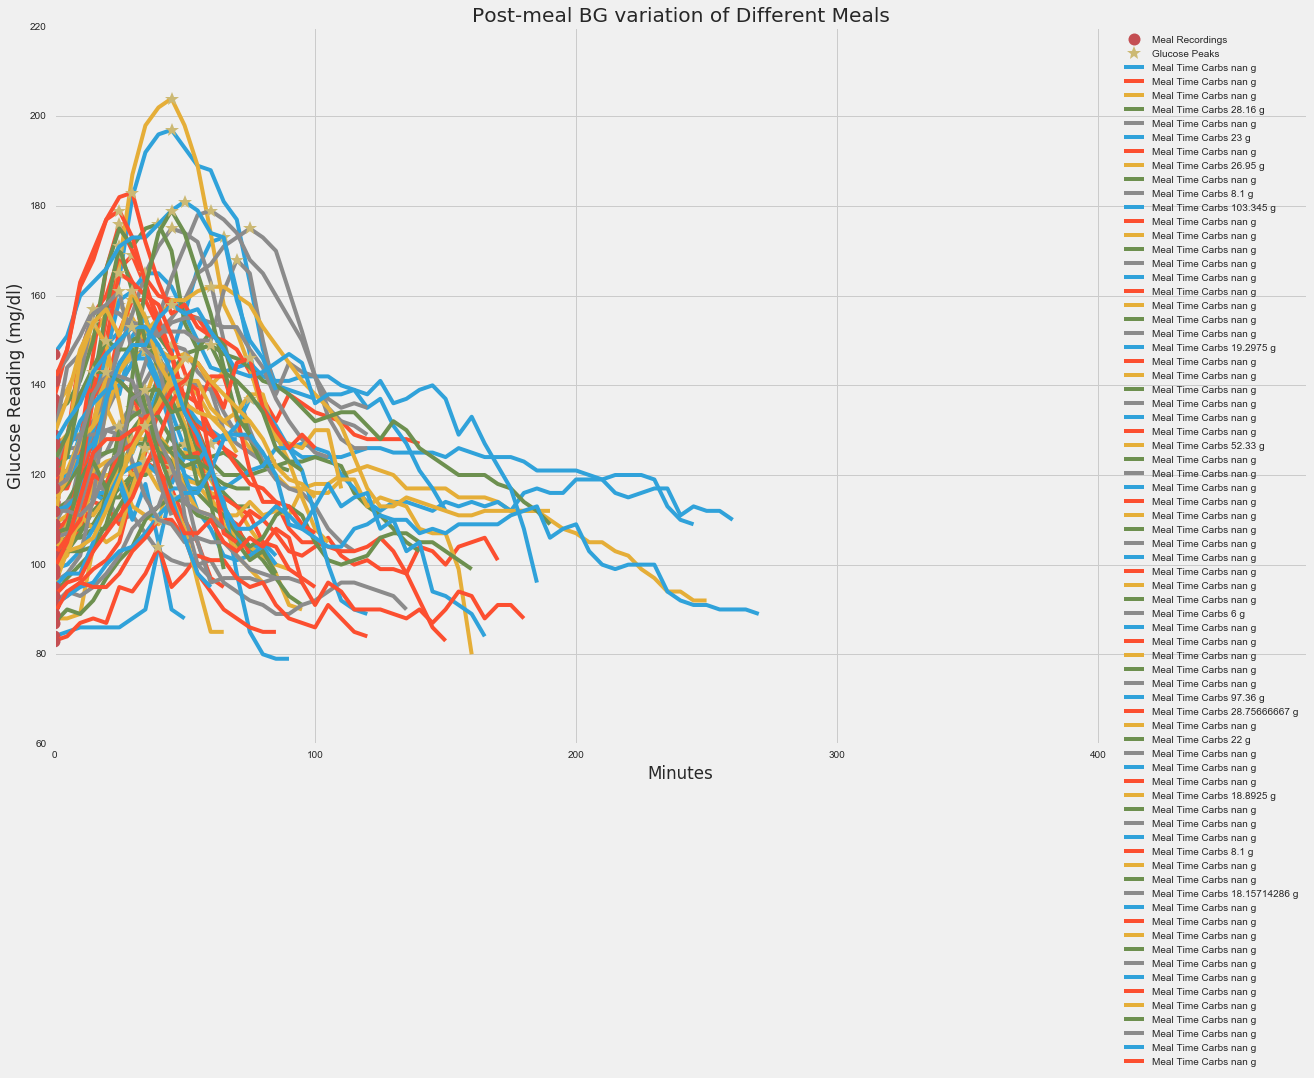

In [598]:
df_all_plots_v2 = pd.DataFrame(columns=Plot_window)

#df_all_plots_v2: contains the full postprandial signals for all meals
#df_P_meals_w_deletion_v3: contains the meal time readings and their info

Plot_extraction_v2(df_P_meals_w_deletion_v3, df_all_plots_v2)
plotting(df_all_plots_v2, df_P_meals_w_deletion_v3)

#print "size of df containing meals is:", df_P_meals_w_deletion_v3.shape[0]
#print "size of df containing plots of all meals is:", df_all_plots_v2.shape[0]

In [599]:
#print_full(all_signals_df_cleaned)
#print all_signals_df_cleaned.shape[0]

print(df_all_plots_v2.shape[0])

def remove_short_signals(period_signals):
    #Detect first NaN occurance on the signal, if less than 90 minutes remove that signal
    global signal_incomplete
    signal_incomplete = []
    for j in range(period_signals.shape[0]):
        #print "j is:", j 
        #print period_signals.iloc[j]
        out = np.argwhere(np.isnan(period_signals.iloc[j]))
        try:
            out[0][0]
        except IndexError:
            #print "full signal, no NAN"   
            continue   
        #print out[0][0]
        #print "j is:", out[0]
        if ((out[0][0]*5) < signal_duration): #if signal is less than 90 minutes
            signal_incomplete.extend([j])

remove_short_signals(df_all_plots_v2)  

#print signal_incomplete  
print(len(signal_incomplete), "signals are removed from all postprandial signals.\n")
df_all_plots_v2.drop(df_all_plots_v2.index[signal_incomplete], axis=0,inplace=True)
df_all_plots_v2 = df_all_plots_v2.reset_index(drop=True)

print("Total remaining meals are:", df_all_plots_v2.shape[0])


72
6 signals are removed from all postprandial signals.

Total remaining meals are: 66


In [600]:
#print_full(breakfast_signals_df)

#Replace time instances with several nan BG concentrations with full column of nan, so it is not biased to specific signals
def replacenansignals(period_signal_df):

    for k in range(period_signal_df.shape[1]):
        #print breakfast_signals_df[breakfast_signals_df.columns[k]]
        xaxis_size =  period_signal_df.shape[0]
        total_nan = sum(pd.isnull(period_signal_df[period_signal_df.columns[k]]))
        available_readings = xaxis_size - total_nan
        #print available_readings

        if (available_readings < least_num_signals_per_inst):#if there are less than 4 signals at some time instance, don't consider them. Only if more than 3
            period_signal_df[period_signal_df.columns[k]] = np.nan
        #print period_signal_df[period_signal_df.columns[k]]     


replacenansignals(df_all_plots_v2) 

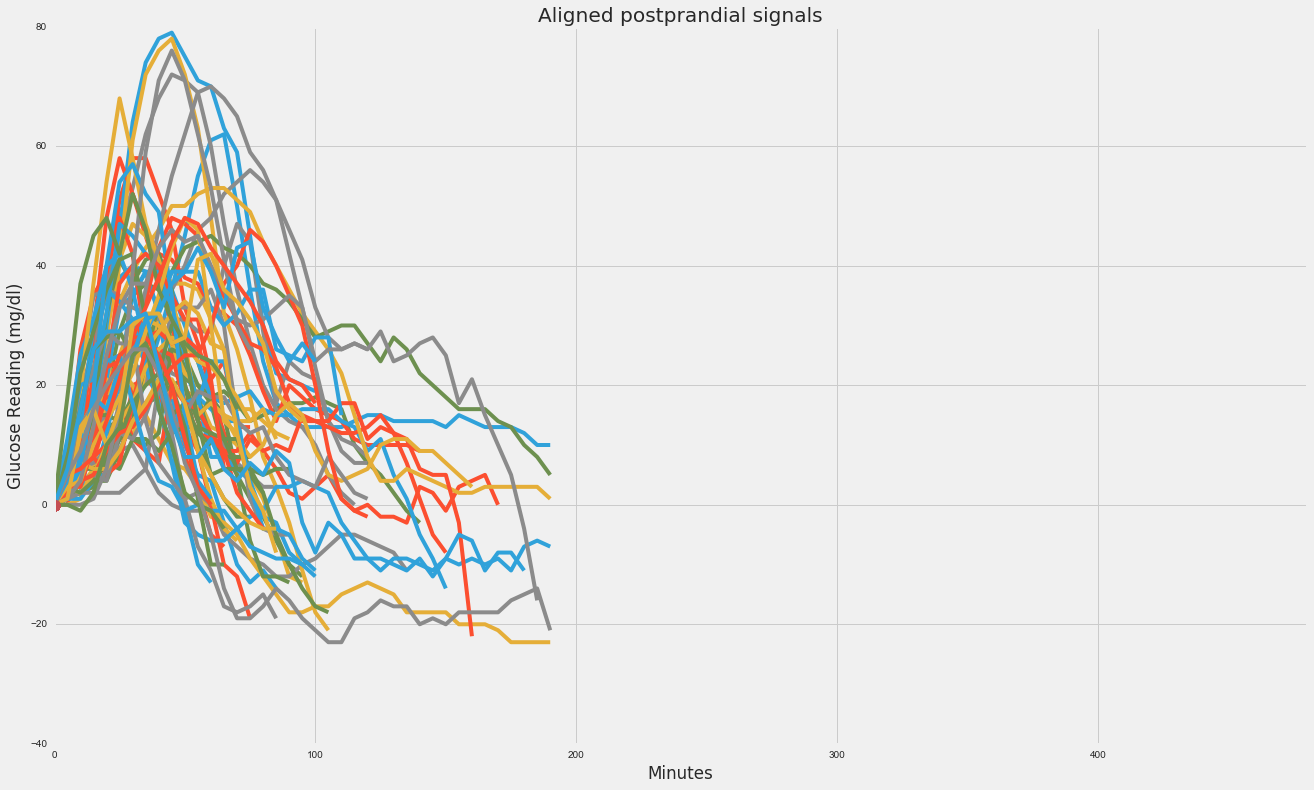

In [601]:
from sklearn import preprocessing

def alignmentandnormalization(df_period_plots):

    global signals_normalized_df 
    signals_normalized_df = copy.deepcopy(df_period_plots)
    global signals_aligned_df 
    signals_aligned_df = copy.deepcopy(df_period_plots)
    
    signalsdf_wo_nan = pd.DataFrame()

   
    for j in range(len(df_period_plots)):
    #signalsdf_wo_nan[j] = df_all_plots_v2.iloc[j][~np.isnan(df_all_plots_v2.iloc[j])]

        signal_wo_nan = df_period_plots.iloc[j][~np.isnan(df_period_plots.iloc[j])]
        aligned_signal = [x - df_period_plots.iloc[j,0] for x in signal_wo_nan]

        reshaped_signal= np.reshape(aligned_signal, (len(aligned_signal), 1))

        signals_aligned_df.iloc[j,0:len(aligned_signal)] = aligned_signal 
        signals_aligned_df.iloc[j,len(aligned_signal):df_period_plots.shape[1]] = np.nan

def plotsaligned(periodmeals, full_postprandials):
    #print "\nPostprandial signals aligned...\n"
    
    alignmentandnormalization(full_postprandials)
    
    plt.figure(figsize=(20,12))

    #for j in range(1,20):
    for j in range(len(signals_aligned_df)):
        #print df_all_plots_v2.iloc[j]
        row = signals_aligned_df.iloc[j]
        #if (round((df_P_meals_w_deletion_v3['CHO (g)'][j]),2) < 35):
        row.plot(label = '')
        #row.plot(label='Meal Time Carbs {} g'.format(round((periodmeals['CHO (g)'][j]),2)))
        plt.plot(0, signals_aligned_df[0][j], 'ro', markersize=12)     


    plt.xlabel('Minutes')
    plt.ylabel('Glucose Reading (mg/dl)')
    plt.legend(loc='upper right')
    title = 'Aligned postprandial signals'
    plt.title(title);
    
plotsaligned(df_P_meals_w_deletion_v3, df_all_plots_v2) 
all_signals_df = copy.deepcopy(signals_aligned_df)

In [602]:


#Spline regression

index_meal_row = []
meal_pts = []
for k in range(len(df_all_plots_v2)):   
    for i,j in enumerate(df_all_plots_v2.iloc[k]):
        if(np.isnan(j)):
            continue
        else:
            meal_pts.append(j)
            index_meal_row.append(i)
            
x = index_meal_row   
y = meal_pts

In [603]:

#mean_of_all = np.mean(all_signals_df) #aligned signals
mean_of_all = np.mean(df_all_plots_v2) #not aligned signals
#print (mean_of_all)

mean_signal = mean_of_all[:][~np.isnan(mean_of_all[:])]

# prandial_mean_instances = [round(item,2) for x, item in enumerate(mean_of_all)]
# mean_signal = []

# Arr = [~np.isnan(prandial_mean_instances[:])]
# for k, x in enumerate(prandial_mean_instances):
#     if (Arr[0][k] == True):
#         mean_signal.append(x)
# print (type(mean_signal[7]))

# mean_pts = [float(np_float) for np_float in mean_signal]
# # print (mean_pts)
# print (type(mean_pts[7]))

plot_indeces = list(map(lambda v : v * 5, range(len(mean_signal))))

print (mean_signal)


0      109.530303
5      113.287879
10     118.939394
15     124.712121
20     130.318182
25     135.409091
30     138.984848
35     140.181818
40     140.060606
45     138.969697
50     135.803030
55     133.060606
60     129.742424
65     127.245902
70     126.035088
75     123.903846
80     121.260870
85     118.931818
90     118.736842
95     119.029412
100    119.066667
105    118.200000
110    116.347826
115    115.090909
120    114.333333
125    114.875000
130    113.875000
135    112.625000
140    112.733333
145    111.076923
150    109.846154
155    111.000000
160    109.454545
165    112.666667
170    111.666667
175    112.000000
180    110.625000
185    111.857143
190    112.333333
dtype: float64


In [604]:
columns = ['logratio', 'std_range']
print (y)

df3 = pd.DataFrame(columns=['logratio', 'std_range'])
df3['logratio']=y
df3['std_range']=x
df3.loc[:,'std_range'] *= 5
#print(df3)

[116.0, 121.0, 125.0, 126.0, 137.0, 138.0, 151.0, 155.0, 148.0, 134.0, 126.0, 121.0, 120.0, 113.0, 106.0, 103.0, 105.0, 102.0, 102.0, 103.0, 108.0, 114.0, 113.0, 109.0, 122.0, 123.0, 121.0, 117.0, 110.0, 105.0, 97.0, 95.0, 103.0, 105.0, 110.0, 117.0, 122.0, 125.0, 128.0, 128.0, 127.0, 121.0, 122.0, 121.0, 116.0, 115.0, 113.0, 108.0, 104.0, 98.0, 91.0, 90.0, 103.0, 106.0, 113.0, 116.0, 115.0, 115.0, 120.0, 120.0, 123.0, 130.0, 131.0, 127.0, 120.0, 112.0, 108.0, 104.0, 101.0, 97.0, 93.0, 91.0, 101.0, 110.0, 123.0, 122.0, 115.0, 110.0, 111.0, 107.0, 103.0, 101.0, 100.0, 100.0, 101.0, 96.0, 94.0, 92.0, 91.0, 89.0, 89.0, 91.0, 92.0, 94.0, 96.0, 96.0, 95.0, 94.0, 93.0, 90.0, 111.0, 113.0, 115.0, 116.0, 116.0, 120.0, 125.0, 132.0, 139.0, 147.0, 156.0, 166.0, 172.0, 173.0, 161.0, 147.0, 135.0, 128.0, 126.0, 124.0, 124.0, 124.0, 124.0, 125.0, 126.0, 126.0, 125.0, 125.0, 125.0, 125.0, 124.0, 126.0, 125.0, 124.0, 124.0, 124.0, 123.0, 121.0, 121.0, 117.0, 117.0, 125.0, 139.0, 155.0, 166.0, 169.0, 

[109.53030303030303, 113.28787878787878, 118.93939393939394, 124.71212121212122, 130.3181818181818, 135.4090909090909, 138.9848484848485, 140.1818181818182, 140.06060606060606, 138.96969696969697, 135.8030303030303, 133.06060606060606, 129.74242424242425, 127.24590163934427, 126.03508771929825, 123.90384615384616, 121.26086956521739, 118.93181818181819, 118.73684210526316, 119.02941176470588, 119.06666666666666, 118.2, 116.34782608695652, 115.0909090909091, 114.33333333333333, 114.875, 113.875, 112.625, 112.73333333333333, 111.07692307692308, 109.84615384615384, 111.0, 109.45454545454545, 112.66666666666667, 111.66666666666667, 112.0, 110.625, 111.85714285714286, 112.33333333333333]
[5, 15, 25]
[115.5545707664452, 132.1181968209163, 134.69083293982203]
[70, 125, 155]
[131.29726803736412, 107.56315622344846, 114.39411924633896]
[10, 40, 100, 130, 150]
[120.38118146725901, 138.54454271645591, 113.54491204040824, 116.67135405674344, 110.15326573571656]
[5, 35, 65, 95, 125, 160]
[114.11741

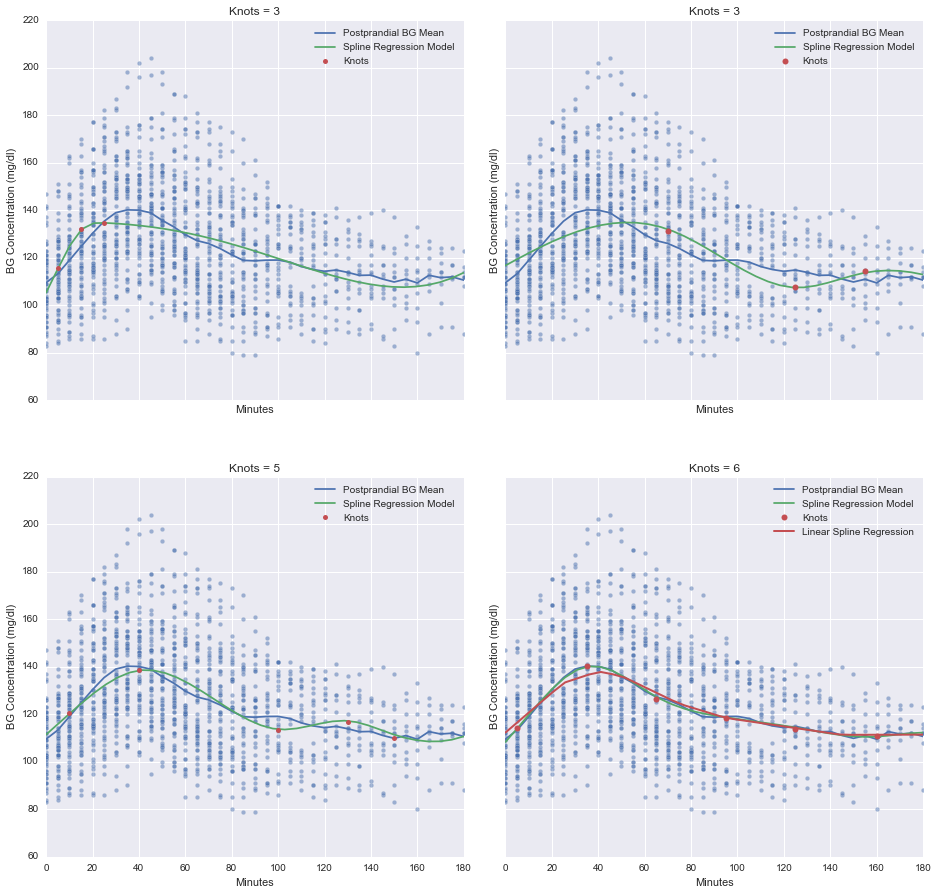

In [605]:
import seaborn as sns
sns.set(color_codes=True)

print (mean_signal.tolist())

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, squeeze=True, figsize=(14, 14))
ax0 = (np.ravel(axes)[0])
ax1 = (np.ravel(axes)[1])
ax2 = (np.ravel(axes)[2])
ax3 = (np.ravel(axes)[3])

ax0.scatter(df3.std_range, df3.logratio, c=blue, alpha=0.5, label = '')
ax1.scatter(df3.std_range, df3.logratio, c=blue, alpha=0.5, label = '')
ax2.scatter(df3.std_range, df3.logratio, c=blue, alpha=0.5, label = '')
ax3.scatter(df3.std_range, df3.logratio, c=blue, alpha=0.5, label = '')

ax0.plot(mean_signal.index, mean_signal.tolist(), label = 'Postprandial BG Mean')
ax1.plot(mean_signal.index, mean_signal.tolist(), label = 'Postprandial BG Mean')
ax2.plot(mean_signal.index, mean_signal.tolist(), label = 'Postprandial BG Mean')
ax3.plot(mean_signal.index, mean_signal.tolist(), label = 'Postprandial BG Mean')

###################### this can be in function, to be recalled
q = 4

#knots = df3.std_range.quantile(np.linspace(0, 1, q))
knots = [5, 15, 25]
#print (knots)
#knots.pop(0)
knots_x = []
knots_y = []

q -= 1
y, X = patsy.dmatrices('logratio ~ std_range + R_(std_range)', data=df3)
S = np.zeros((q + 2, q + 2))
S[2:, 2:] = R_(knots)

B = np.zeros_like(S)
B[2:, 2:] = np.real_if_close(sp.linalg.sqrtm(S[2:, 2:]), tol=10**8)

plot_x = np.linspace(0, df3.std_range.iloc[-1], df3.std_range.iloc[-1]/5)
plot_X = patsy.dmatrix('std_range + R_(std_range)', {'std_range': plot_x})
    
results = fit(y, X, B)


ax0.plot(plot_x, results.predict(plot_X), label = 'Spline Regression Model');

for c in range(len(knots)):
    #print (int(knots.iloc[c]))
    knots_x.append(knots[c])
    indx = int(knots[c]/5) 
    #print(results.predict(plot_X)[indx])
    knots_y.append(results.predict(plot_X)[indx])

print (knots_x)
print (knots_y)
ax0.plot(knots_x, knots_y, 'ro', label="Knots", markersize=5)

ax0.set_xlim(0, df3.std_range.iloc[-1]);
ax0.set_xlabel('Minutes');

ax0.set_ylabel('BG Concentration (mg/dl)');
ax0.set_title('Knots = 3');

############################
q = 4

knots = df3.std_range.quantile(np.linspace(0, 1, q))
knots = [70, 125, 155]
#knots.pop(1)
knots_x = []
knots_y = []

q -= 1
y, X = patsy.dmatrices('logratio ~ std_range + R_(std_range)', data=df3)
S = np.zeros((q + 2, q + 2))
S[2:, 2:] = R_(knots)

B = np.zeros_like(S)
B[2:, 2:] = np.real_if_close(sp.linalg.sqrtm(S[2:, 2:]), tol=10**8)

plot_x = np.linspace(0, df3.std_range.iloc[-1], df3.std_range.iloc[-1]/5)
plot_X = patsy.dmatrix('std_range + R_(std_range)', {'std_range': plot_x})
    
results = fit(y, X, B)

ax1.plot(plot_x, results.predict(plot_X), label = 'Spline Regression Model');

for c in range(len(knots)):
    #print (int(knots.iloc[c]))
    knots_x.append(knots[c])
    indx = int(knots[c]/5)
    #print(results.predict(plot_X)[indx])
    knots_y.append(results.predict(plot_X)[indx])

print (knots_x)
print (knots_y)
ax1.plot(knots_x, knots_y, 'ro', label="Knots", markersize=6)

ax1.set_xlim(0, df3.std_range.iloc[-1]);
ax1.set_xlabel('Minutes');
ax1.set_ylabel('BG Concentration (mg/dl)');
ax1.set_title('Knots = 3');
##################################################
############################
q = 6

knots = df3.std_range.quantile(np.linspace(0, 1, q))
knots = [10, 40, 100, 130, 150]
#knots.pop(1)
knots_x = []
knots_y = []

q -= 1
y, X = patsy.dmatrices('logratio ~ std_range + R_(std_range)', data=df3)
S = np.zeros((q + 2, q + 2))
S[2:, 2:] = R_(knots)

B = np.zeros_like(S)
B[2:, 2:] = np.real_if_close(sp.linalg.sqrtm(S[2:, 2:]), tol=10**8)

plot_x = np.linspace(0, df3.std_range.iloc[-1], df3.std_range.iloc[-1]/5)
plot_X = patsy.dmatrix('std_range + R_(std_range)', {'std_range': plot_x})
    
results = fit(y, X, B)

ax2.plot(plot_x, results.predict(plot_X), label = 'Spline Regression Model');

for c in range(len(knots)):
    #print (int(knots.iloc[c]))
    knots_x.append(knots[c])
    indx = int(knots[c]/5)
    #print(results.predict(plot_X)[indx])
    knots_y.append(results.predict(plot_X)[indx])

print (knots_x)
print (knots_y)
ax2.plot(knots_x, knots_y, 'ro', label="Knots", markersize=5)

ax2.set_xlim(0, df3.std_range.iloc[-1]);
ax2.set_xlabel('Minutes');

ax2.set_ylabel('BG Concentration (mg/dl)');
ax2.set_title('Knots = 5');

################################################## 
############################
q = 7

knots = [5, 35, 65, 95, 125, 160]
#knots.pop(1)
knots_x = []
knots_y = []

q -= 1
y, X = patsy.dmatrices('logratio ~ std_range + R_(std_range)', data=df3)
S = np.zeros((q + 2, q + 2))
S[2:, 2:] = R_(knots)

B = np.zeros_like(S)
B[2:, 2:] = np.real_if_close(sp.linalg.sqrtm(S[2:, 2:]), tol=10**8)

plot_x = np.linspace(0, df3.std_range.iloc[-1], df3.std_range.iloc[-1]/5)
plot_X = patsy.dmatrix('std_range + R_(std_range)', {'std_range': plot_x})
    
results = fit(y, X, B)

ax3.plot(plot_x, results.predict(plot_X), label = 'Spline Regression Model');

for c in range(len(knots)):
    #print (int(knots.iloc[c]))
    knots_x.append(knots[c])
    indx = int(knots[c]/5)
    #print(results.predict(plot_X)[indx])
    knots_y.append(results.predict(plot_X)[indx])

# for c in range(len(knots)):
#     #print (int(knots.iloc[c]))
#     knots_x.append(knots.iloc[c])
#     indx = int(knots.iloc[c]/5)
#     #print(results.predict(plot_X)[indx])
#     knots_y.append(results.predict(plot_X)[indx])

print (knots_x)
print (knots_y)
ax3.plot(knots_x, knots_y, 'ro', label="Knots", markersize=6)
#################################
spline = UnivariateSpline(plot_indeces, mean_signal, k = '1')
print ("knots are: ", (spline.get_knots()))
spline.set_smoothing_factor(100)
print ("knots are: ", (spline.get_knots()))
ax3.plot(plot_x, spline(plot_x), label = 'Linear Spline Regression', linewidth=2.0);  
##################################
ax3.set_xlim(0, df3.std_range.iloc[-1]);
ax3.set_xlabel('Minutes');

ax3.set_ylabel('BG Concentration (mg/dl)');

ax3.set_title('Knots = 6');
################################################## 
ax0.legend(loc='upper right')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
fig.subplots_adjust(wspace=0.1)

plt.show()

[5, 35, 65, 95, 125, 160]
[113.95417785080645, 139.99887470184694, 127.32202159478402, 118.70278023300489, 114.42326961467916, 110.57153177922009]
[ 108.30799656  113.95417785  119.70888714  125.34184229  130.52899737
  134.93455121  138.2109475   139.9988747   140.06363663  138.70426402
  136.34440293  133.39594424  130.25902363  127.32202159  124.88997236
  122.96979065  121.48504492  120.34754842  119.45735923  118.70278023
  117.98413847  117.28512326  116.60144808  115.91707121  115.20419575
  114.42326961  113.55013166  112.65745018  111.83328442  111.15393843
  110.68396108  110.47614603  110.57153178  110.96609711  111.51084767
  112.0117294   112.26293305  112.0468942   111.13429322  109.28405529
  106.24335041  101.74759337   95.52044379   87.27380608   76.70782947
   63.51090799   47.35968049   27.91903063    4.84208686]
knots are:  [   0.   25.   40.   50.   75.   95.  145.  190.]
knots are:  [   0.   25.   40.   50.   75.   95.  145.  190.]


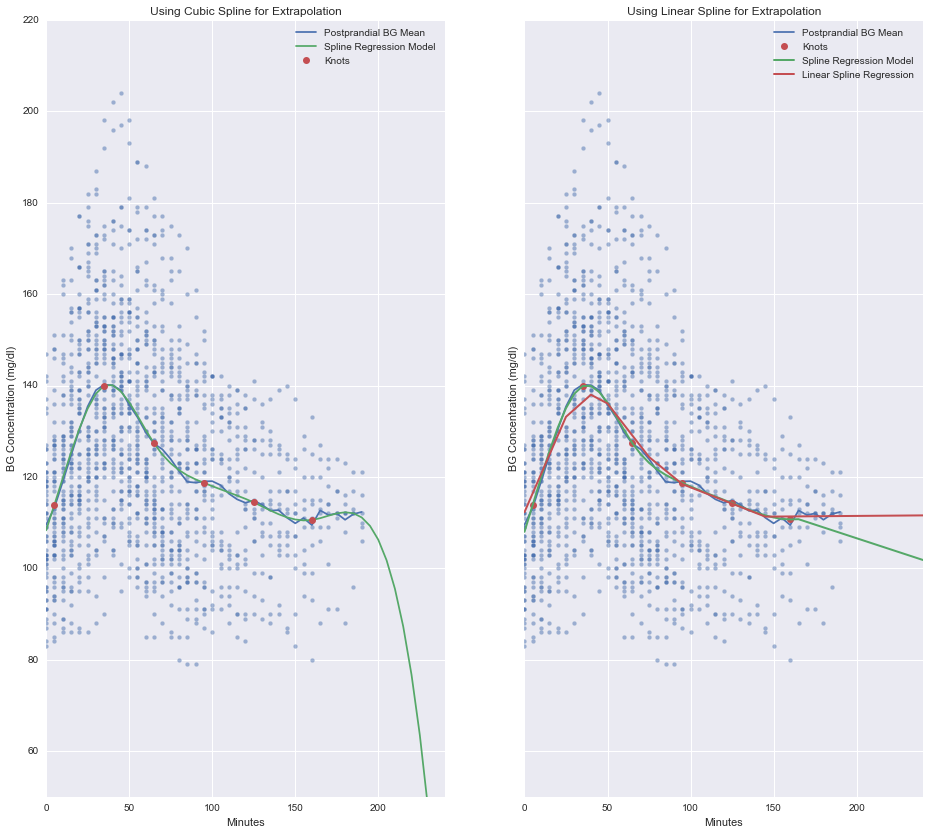

In [606]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, squeeze=True, figsize=(14, 13))
ax0 = (np.ravel(axes)[0])
ax1 = (np.ravel(axes)[1])

ax0.scatter(df3.std_range, df3.logratio, c=blue, alpha=0.5, label = '')
ax1.scatter(df3.std_range, df3.logratio, c=blue, alpha=0.5, label = '')


ax0.plot(mean_signal.index, mean_signal.tolist(), label = 'Postprandial BG Mean')
ax1.plot(mean_signal.index, mean_signal.tolist(), label = 'Postprandial BG Mean')

q = 7

knots = [5, 35, 65, 95, 125, 160]
#knots.pop(1)
knots_x = []
knots_y = []

q -= 1
y, X = patsy.dmatrices('logratio ~ std_range + R_(std_range)', data=df3)
S = np.zeros((q + 2, q + 2))
S[2:, 2:] = R_(knots)

B = np.zeros_like(S)
B[2:, 2:] = np.real_if_close(sp.linalg.sqrtm(S[2:, 2:]), tol=10**8)


extrapolation_mins = 60
plot_x = np.linspace(0, df3.std_range.iloc[-1] + extrapolation_mins, (df3.std_range.iloc[-1] + extrapolation_mins)/5+1)

plot_X = patsy.dmatrix('std_range + R_(std_range)', {'std_range': plot_x})

results = fit(y, X, B, 1.0)

ax0.plot(plot_x, results.predict(plot_X), label = 'Spline Regression Model');

for c in range(len(knots)):
    #print (int(knots.iloc[c]))
    knots_x.append(knots[c])
    indx = int(knots[c]/5)
    #print(results.predict(plot_X)[indx])
    knots_y.append(results.predict(plot_X)[indx])

print (knots_x)
print (knots_y)
ax0.plot(knots_x, knots_y, 'ro', label="Knots", markersize=7)


print (results.predict(plot_X))

last_knot = knots_x[-1]/5
last_knot_pos = int(((df3.std_range.iloc[-1]/5)-last_knot)+2)


def extrap1d(interpolator):
    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        if x < xs[0]:
            return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        elif x > xs[-(last_knot_pos)]:
            
            y1 = sum(ys[-(last_knot_pos + 2):-(last_knot_pos)])
            y2 = sum(ys[-(last_knot_pos + 4):-(last_knot_pos + 2)])
            return ys[-(last_knot_pos)]+(x-xs[-(last_knot_pos)])*(y1-y2)/((xs[-1]-xs[-2])*2)#-3 or -2 depending on which points we are considering
            #return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])#-3 or -2 depending on which points we are considering
        else:
            return interpolator(x)

    def ufunclike(xs):
        return array(list(map(pointwise, array(xs))))

    return ufunclike

knots_x =[]
knots_y =[]
results = fit(y, X, B, 10.0)
for c in range(len(knots)):
    #print (int(knots.iloc[c]))
    knots_x.append(knots[c])
    indx = int(knots[c]/5)
    #print(results.predict(plot_X)[indx])
    knots_y.append(results.predict(plot_X)[indx])
ax1.plot(knots_x, knots_y, 'ro', label="Knots", markersize=7)
    

spl = interp1d(mean_signal.index, results.predict(plot_X)[:len(mean_signal.index)])
extrapolate_spline = extrap1d(spl)
ax1.plot(plot_x, extrapolate_spline(plot_x) , label = 'Spline Regression Model', linewidth=2.0);  
 
    
    
#################################
spline = UnivariateSpline(plot_indeces, mean_signal, k = '1')
print ("knots are: ", (spline.get_knots()))
spline.set_smoothing_factor(100)
print ("knots are: ", (spline.get_knots()))
ax1.plot(plot_x, spline(plot_x), label = 'Linear Spline Regression', linewidth=2.0);  
##################################


ax0.set_xlim(0, df3.std_range.iloc[-1] + extrapolation_mins);
ax0.set_xlabel('Minutes');
ax0.set_ylabel('BG Concentration (mg/dl)');
ax0.set_title('Using Cubic Spline for Extrapolation');
ax1.set_xlim(0, df3.std_range.iloc[-1] + extrapolation_mins);
ax1.set_ylim(50, 220);
ax1.set_xlabel('Minutes');
ax1.set_ylabel('BG Concentration (mg/dl)');
ax1.set_title('Using Linear Spline for Extrapolation');
################################################## 
ax0.legend(loc='upper right')
ax1.legend(loc='upper right')

[ 108.30799656  113.95417785  119.70888714  125.34184229  130.52899737
  134.93455121  138.2109475   139.9988747   140.06363663  138.70426402
  136.34440293  133.39594424  130.25902363  127.32202159  124.88997236
  122.96979065  121.48504492  120.34754842  119.45735923  118.70278023
  117.98413847  117.28512326  116.60144808  115.91707121  115.20419575
  114.42326961  113.55013166  112.65745018  111.83328442  111.15393843
  110.68396108  110.47614603  110.57153178  110.96609711  111.51084767
  112.0117294   112.26293305  112.0468942   111.13429322  109.28405529
  106.24335041  101.74759337   95.52044379   87.27380608   76.70782947
   63.51090799   47.35968049   27.91903063    4.84208686]
knots are:  [   0.   25.   50.   95.  145.  190.]
knots are:  [   0.   25.   50.   95.  145.  190.]

LSQUnivariateSpline knots are: [   0.   35.   65.   95.  125.  190.]


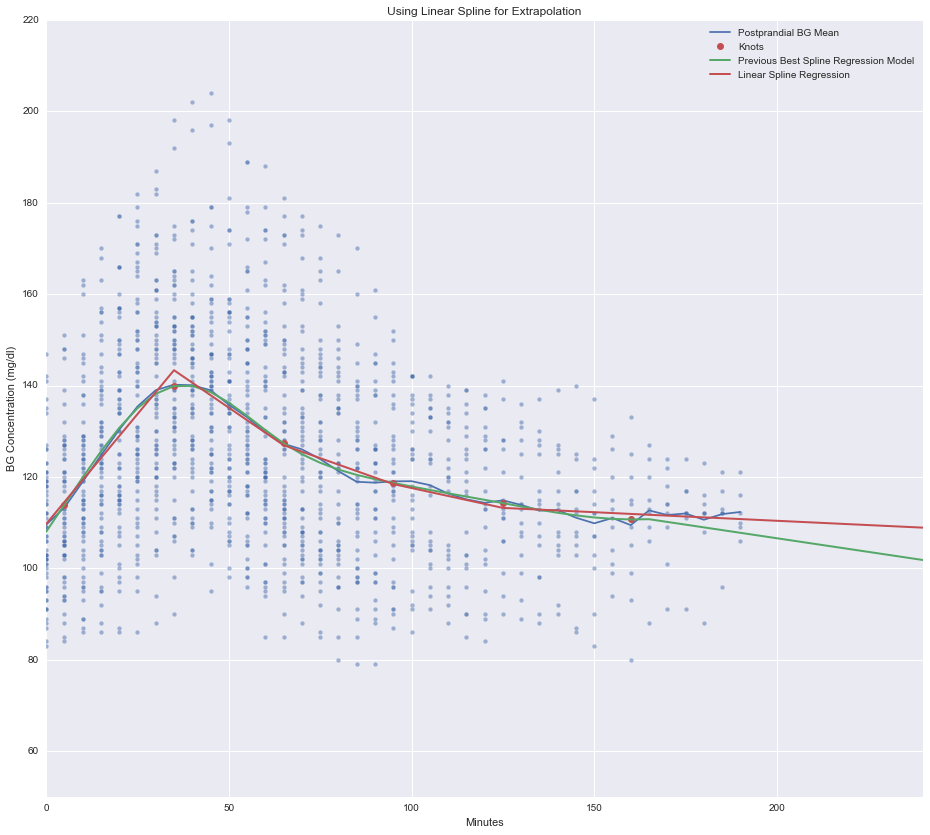

In [658]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, squeeze=True, figsize=(14, 13))
ax1 = (np.ravel(axes)[0])

ax1.scatter(df3.std_range, df3.logratio, c=blue, alpha=0.5, label = '')

ax1.plot(mean_signal.index, mean_signal.tolist(), label = 'Postprandial BG Mean')

q = 7
#[   0.   25.   40.   50.   75.   95.  145.  190.]
#knots = [5, 35, 65, 95, 125, 160]
knots = [5, 35, 65, 95, 125, 160]
#knots.pop(1)
knots_x = []
knots_y = []

q -= 1
y, X = patsy.dmatrices('logratio ~ std_range + R_(std_range)', data=df3)
S = np.zeros((q + 2, q + 2))
S[2:, 2:] = R_(knots)

B = np.zeros_like(S)
B[2:, 2:] = np.real_if_close(sp.linalg.sqrtm(S[2:, 2:]), tol=10**8)


extrapolation_mins = 60
plot_x = np.linspace(0, df3.std_range.iloc[-1] + extrapolation_mins, (df3.std_range.iloc[-1] + extrapolation_mins)/5+1)

plot_X = patsy.dmatrix('std_range + R_(std_range)', {'std_range': plot_x})

results = fit(y, X, B, 1.0)

for c in range(len(knots)):
    #print (int(knots.iloc[c]))
    knots_x.append(knots[c])
    indx = int(knots[c]/5)
    #print(results.predict(plot_X)[indx])
    knots_y.append(results.predict(plot_X)[indx])

print (results.predict(plot_X))

last_knot = knots_x[-1]/5
last_knot_pos = int(((df3.std_range.iloc[-1]/5)-last_knot)+2)


def extrap1d(interpolator):
    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        if x < xs[0]:
            return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        elif x > xs[-(last_knot_pos)]:
            
            y1 = sum(ys[-(last_knot_pos + 2):-(last_knot_pos)])
            y2 = sum(ys[-(last_knot_pos + 4):-(last_knot_pos + 2)])
            return ys[-(last_knot_pos)]+(x-xs[-(last_knot_pos)])*(y1-y2)/((xs[-1]-xs[-2])*2)#-3 or -2 depending on which points we are considering
            #return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])#-3 or -2 depending on which points we are considering
        else:
            return interpolator(x)

    def ufunclike(xs):
        return array(list(map(pointwise, array(xs))))

    return ufunclike

knots_x =[]
knots_y =[]
results = fit(y, X, B, 10.0)
for c in range(len(knots)):
    #print (int(knots.iloc[c]))
    knots_x.append(knots[c])
    indx = int(knots[c]/5)
    #print(results.predict(plot_X)[indx])
    knots_y.append(results.predict(plot_X)[indx])
ax1.plot(knots_x, knots_y, 'ro', label="Knots", markersize=7)
    

spl = interp1d(mean_signal.index, results.predict(plot_X)[:len(mean_signal.index)])
extrapolate_spline = extrap1d(spl)
ax1.plot(plot_x, extrapolate_spline(plot_x) , label = 'Previous Best Spline Regression Model', linewidth=2.0);  
 
    
    
#################################
spline = UnivariateSpline(plot_indeces, mean_signal, k = '1', s='100')
print ("knots are: ", (spline.get_knots()))
#spline.set_smoothing_factor(1000)
print ("knots are: ", (spline.get_knots()))
#ax1.plot(plot_x, spline(plot_x), label = 'Linear Spline Regression', linewidth=2.0);  
##################################

LSQ_USpline = LSQUnivariateSpline(plot_indeces, mean_signal, knots[1:-1], k = 1)
print ("\nLSQUnivariateSpline knots are:", LSQ_USpline.get_knots())
ax1.plot(plot_x, LSQ_USpline(plot_x), label = 'Linear Spline Regression', linewidth=2.0);  

   


ax0.set_xlim(0, df3.std_range.iloc[-1] + extrapolation_mins);
ax0.set_xlabel('Minutes');
ax0.set_ylabel('BG Concentration (mg/dl)');
ax0.set_title('Using Cubic Spline for Extrapolation');
ax1.set_xlim(0, df3.std_range.iloc[-1] + extrapolation_mins);
ax1.set_ylim(50, 220);
ax1.set_xlabel('Minutes');
ax1.set_ylabel('BG Concentration (mg/dl)');
ax1.set_title('Using Linear Spline for Extrapolation');
################################################## 
ax0.legend(loc='upper right')
ax1.legend(loc='upper right')

180

LSQUnivariateSpline knots are: [   0.   35.   95.  190.]
UnivariateSpline knots are:  [   0.   25.   40.   50.   75.   95.  145.  190.]

LSQUnivariateSpline knots are: [   0.   35.   95.  190.]
UnivariateSpline knots are:  [   0.   25.   35.   40.   50.   65.   75.   85.   95.  120.  145.  155.
  160.  165.  170.  180.  190.]

LSQUnivariateSpline knots are: [   0.   35.   95.  190.]
UnivariateSpline knots are:  [   0.    5.   10.   15.   25.   30.   35.   40.   45.   50.   65.   75.
   85.   95.  105.  110.  120.  125.  130.  135.  140.  145.  150.  155.
  160.  165.  170.  175.  180.  190.]

LSQUnivariateSpline knots are: [   0.   35.   95.  190.]
UnivariateSpline knots are:  [   0.    5.   10.   15.   20.   25.   30.   35.   40.   45.   50.   55.
   60.   65.   70.   75.   85.   95.  100.  105.  110.  120.  125.  130.
  135.  140.  145.  150.  155.  160.  165.  170.  175.  180.  185.  190.]

LSQUnivariateSpline knots are: [   0.   35.   95.  190.]
UnivariateSpline knots are:  [ 

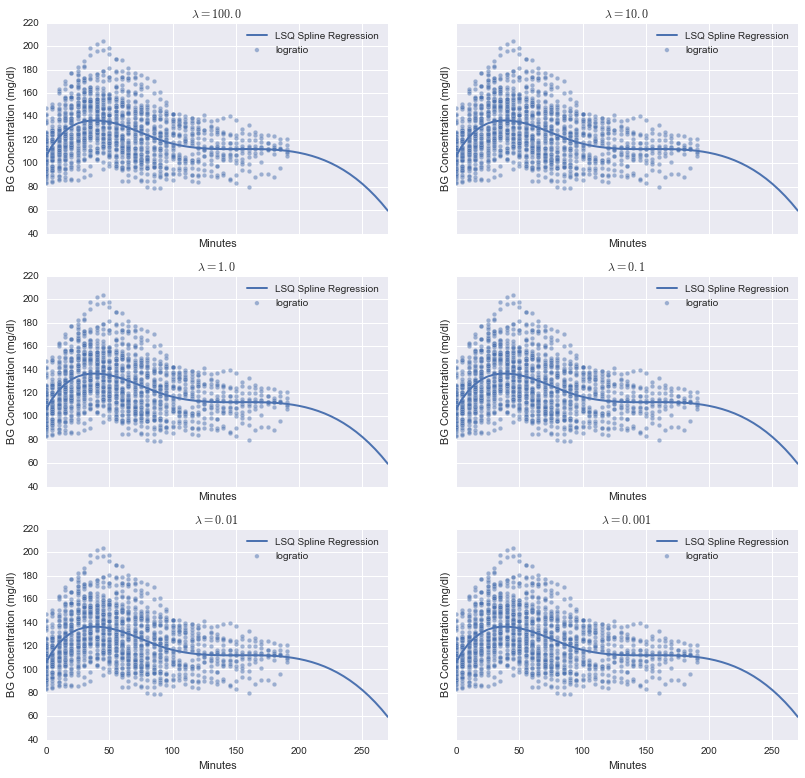

In [653]:
from scipy.interpolate import LSQUnivariateSpline

print (df3.std_range.iloc[-1])

org_knots = [5, 35,  95,  160]

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, squeeze=True, figsize=(12, 12))

plot_lambdas = np.array([100.0, 10.0, 1.0, 0.1, 0.01, 0.001])

extrapolation_mins = 90
plot_x = np.linspace(0, df3.std_range.iloc[-1] + extrapolation_mins, (df3.std_range.iloc[-1] + extrapolation_mins)/5 +1)
plot_x.astype(int)


#spline = UnivariateSpline(plot_indeces, mean_signal, k = '1', s='100')

for lambda_, ax in zip(plot_lambdas, np.ravel(axes)):
    spline = UnivariateSpline(plot_indeces, mean_signal, k = '1')
    ax.scatter(df3.std_range, df3.logratio, c=blue, alpha=0.5);
   

    LSQ_USpline = LSQUnivariateSpline(plot_indeces, mean_signal, org_knots[1:-1], k = 3)
    print ("\nLSQUnivariateSpline knots are:", LSQ_USpline.get_knots())
    LSQ_USpline.set_smoothing_factor(lambda_)
    ax.plot(plot_x, LSQ_USpline(plot_x), label = 'LSQ Spline Regression', linewidth=2.0);  
    
    
    ############
    knots_x = []
    knots_y = [] 
    
    ################################
    #print ("knots are: ", (spline.get_knots()))

    spline.set_smoothing_factor(lambda_)
    print ("UnivariateSpline knots are: ", (spline.get_knots()))
    #ax.plot(plot_x, spline(plot_x), label = 'Linear Spline Regression', linewidth=2.0);  
    ##################################
    
    knots = spline.get_knots()
    
    for c in range(len(knots)):
        knots_x.append(knots[c])
        indx = int(knots[c]/5)
        #print(results.predict(plot_X)[indx])
        knots_y.append(results.predict(plot_X)[indx])
    #ax.plot(knots_x, knots_y, 'ro', label="Knots", markersize=7)
 
    ax.set_xlim(0, df3.std_range.iloc[-1] + 90);
    ax.set_xlabel('Minutes');
    
    ax.set_ylabel('BG Concentration (mg/dl)');
    
    ax.set_title(r'$\lambda = {}$'.format(lambda_));
    ax.legend(loc='upper right')

180
0.000000      0.0
0.071429      5.0
0.142857     15.0
0.214286     20.0
0.285714     30.0
0.357143     35.0
0.428571     45.0
0.500000     55.0
0.571429     60.0
0.642857     70.0
0.714286     80.0
0.785714     90.0
0.857143    110.0
0.928571    140.0
1.000000    190.0
Name: std_range, dtype: float64
[   0.    5.   10.   15.   20.   25.   30.   35.   40.   45.   50.   55.
   60.   65.   70.   75.   80.   85.   90.   95.  100.  105.  110.  115.
  120.  125.  130.  135.  140.  145.  150.  155.  160.  165.  170.  175.
  180.  185.  190.  195.  200.  205.  210.  215.  220.  225.  230.  235.
  240.  245.  250.  255.  260.  265.  270.]


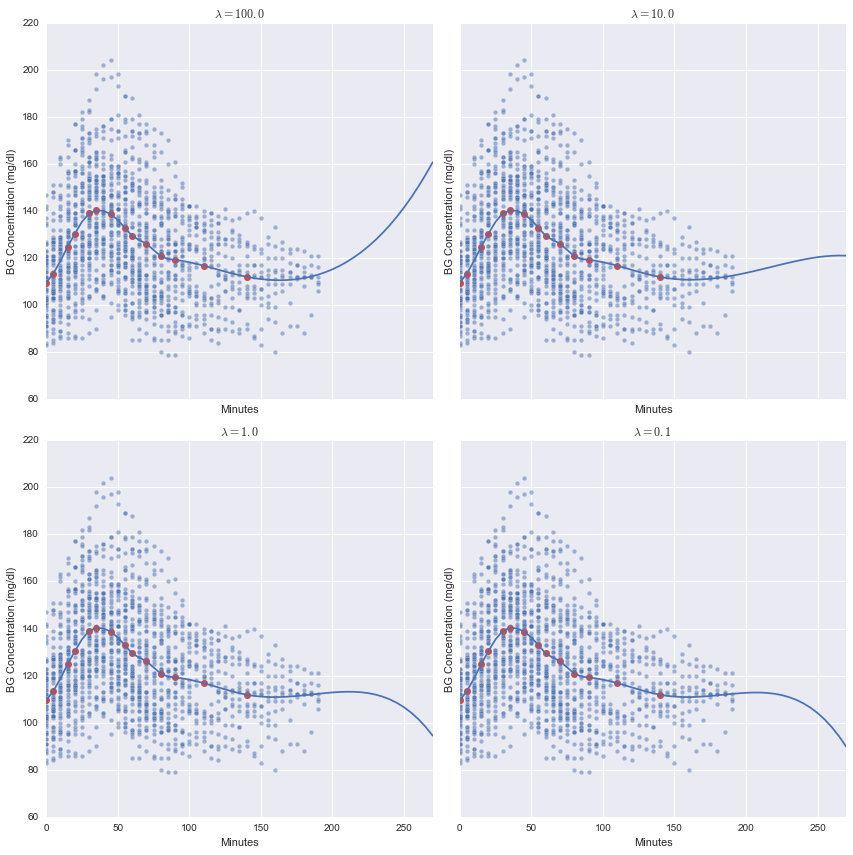

In [636]:
print (df3.std_range.iloc[-1])

q = 15

knots = df3.std_range.quantile(np.linspace(0, 1, q))

print (knots)
#knots = [5, 35, 65, 95, 125, 160]
knots.pop(1)
q -= 1

y, X = patsy.dmatrices('logratio ~ std_range + R_(std_range)', data=df3)

S = np.zeros((q + 2, q + 2))
S[2:, 2:] = R_(knots)

B = np.zeros_like(S)
B[2:, 2:] = np.real_if_close(sp.linalg.sqrtm(S[2:, 2:]), tol=10**8)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, squeeze=True, figsize=(12, 12))

plot_lambdas = np.array([100.0, 10.0, 1.0, 0.1])


extrapolation_mins = 90
plot_x = np.linspace(0, df3.std_range.iloc[-1] + extrapolation_mins, (df3.std_range.iloc[-1] + extrapolation_mins)/5 +1)
plot_x.astype(int)

print (plot_x)
plot_X = patsy.dmatrix('std_range + R_(std_range)', {'std_range': plot_x})

for lambda_, ax in zip(plot_lambdas, np.ravel(axes)):
    ax.scatter(df3.std_range, df3.logratio, c=blue, alpha=0.5);
    
    
    
    
    
    knots_x = []
    knots_y = [] 
    
    results = fit(y, X, B, lambda_=lambda_)
   
    for c in range(len(knots)):
        #print (int(knots.iloc[c]))
        #knots_x.append(knots[c])
        knots_x.append(knots.iloc[c])
        #indx = int(knots[c]/5)
        indx = int(knots.iloc[c]/5)
        #print(results.predict(plot_X)[indx])
        knots_y.append(results.predict(plot_X)[indx])
    ax.plot(knots_x, knots_y, 'ro', label="Knots", markersize=7)
 
    ax.plot(plot_x, results.predict(plot_X));
    
    ax.set_xlim(0, df3.std_range.iloc[-1] + 90);
    ax.set_xlabel('Minutes');
    
    ax.set_ylabel('BG Concentration (mg/dl)');
    
    ax.set_title(r'$\lambda = {}$'.format(lambda_));

fig.tight_layout();

In [609]:
import sklearn
print(sklearn.__version__)

0.19.1


0.000000      0.0
0.333333     35.0
0.666667     75.0
1.000000    190.0
Name: std_range, dtype: float64
knots are:  [   0.   15.   25.   50.   95.  190.]
knots are:  [   0.   15.   25.   50.   95.  190.]
[106.71342821661088, 127.23885176186425, 135.39706329580693, 134.68400325954306, 118.60021469353588, 111.38598063396053]
[ 106.71342822  114.28020422  121.22684727  127.23885176  132.02622966
  135.3970633   137.26027209  137.83005351  137.39692453  136.25140212
  134.68400326  132.9428196   131.10624152  129.21023405  127.29076224
  125.38379113  123.52528578  121.75121123  120.09753252  118.60021469
  117.28701355  116.15284786  115.18442715  114.36846093  113.69165873
  113.14073006  112.70238444  112.3633314   112.11028046  111.92994113
  111.80902293  111.73423539  111.69228802  111.66989035  111.6537519
  111.63058218  111.58709072  111.50998703  111.38598063]
knots are:  [   0.   15.   25.   50.   95.  190.]
knots are:  [   0.   15.   25.   50.   65.   75.   85.   95.  110.  120

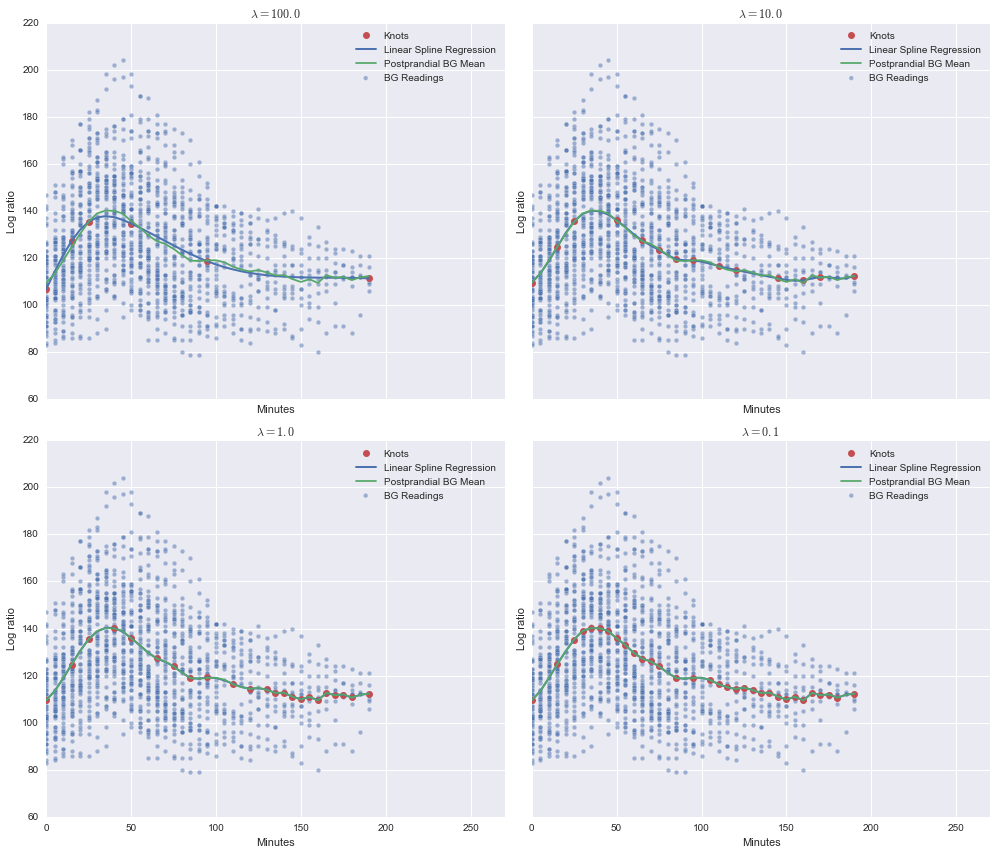

In [663]:
import time
from numpy import array
import statsmodels.api as sm
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection  import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared


#polynomial regression

p = np.poly1d(np.polyfit(df3.std_range, df3.logratio, deg=5))

######

def extrap1d(interpolator):
    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        if x < xs[0]:
            return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        elif x > xs[-1]:
            return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-3])/(xs[-1]-xs[-3])#-3 or -2 depending on which points we are considering
        else:
            return interpolator(x)

    def ufunclike(xs):
        return array(list(map(pointwise, array(xs))))

    return ufunclike




q = 4

knots = df3.std_range.quantile(np.linspace(0, 1, q))

print (knots)
knots.pop(1)
q -= 1

y, X = patsy.dmatrices('logratio ~ std_range + R_(std_range)', data=df3)

S = np.zeros((q + 2, q + 2))
S[2:, 2:] = R_(knots)

B = np.zeros_like(S)
B[2:, 2:] = np.real_if_close(sp.linalg.sqrtm(S[2:, 2:]), tol=10**8)
plot_lambdas = np.array([100.0, 10.0, 1.0, 0.1])

#########################
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, squeeze=True, figsize=(14, 12))

extrapolation_mins = 10
plot_x = np.linspace(0, df3.std_range.iloc[-1] + extrapolation_mins, (df3.std_range.iloc[-1] + extrapolation_mins)/5 +1)
plot_X = patsy.dmatrix('std_range + R_(std_range)', {'std_range': plot_x})


for lambda_, ax in zip(plot_lambdas, np.ravel(axes)):
    knots_x = []
    knots_y = []
    ax.scatter(df3.std_range, df3.logratio, c=blue, alpha=0.5, label = 'BG Readings');  
    
    results = fit(y, X, B, lambda_=lambda_)
    
    spline = UnivariateSpline(plot_indeces, mean_signal, k = '3')
    print ("knots are: ", (spline.get_knots()))

    spline.set_smoothing_factor(lambda_)
    
    print ("knots are: ", (spline.get_knots()))
    
    for c, knot in enumerate(spline.get_knots()):
        #print (int(knots.iloc[c]))
        knots_x.append(knot)
        indx = int(knot/5) 
        #print(results.predict(plot_X)[indx])
        knots_y.append(spline(plot_x)[indx])

        
    spl = interp1d(plot_indeces, spline(plot_indeces))
    extrapolate_spline = extrap1d(spl)
    
    ax.plot(knots_x, knots_y, 'ro', label="Knots", markersize=7)   
    #ax.plot(plot_x, p(plot_x), label = 'Polynomial Regression', linewidth=2.0);  
    print   (knots_y)
    #ax.plot(plot_x, extrapolate_spline(plot_x) , label = 'Python UnivariateSpline Regression', linewidth=2.0);  
    
    #ax.plot(plot_x, results.predict(plot_X), label = 'Spline Regression', linewidth=2.0);  
    ax.plot(plot_x, spline(plot_x), label = 'Linear Spline Regression', linewidth=2.0);  
    ax.plot(mean_signal.index, mean_signal.tolist(), label = 'Postprandial BG Mean')   
    print (spline(plot_x))
#     plt.plot(plot_x, y_kr, color='turquoise', lw=1,
#     label='KRR (%s)' % kr.best_params_)
#     plt.plot(plot_x, y_gpr, color='darkorange', lw=1,
#     label='GPR (%s)' % gpr.kernel_)
    
    
    
    ax.set_xlim(0, df3.std_range.iloc[-1]+90);
    ax.set_xlabel('Minutes');
    
    ax.set_ylabel('Log ratio');
    
    ax.set_title(r'$\lambda = {}$'.format(lambda_));

    ax.legend(loc='upper right')

fig.tight_layout();

#print (plot_X)

In [611]:
#################################

# reshaped_x = np.reshape(df3.std_range, (len(df3.std_range), 1))

# # # Fit KernelRidge with parameter selection based on 5-fold cross validation
# param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
#               "kernel": [ExpSineSquared(l, p)
#                          for l in np.logspace(-2, 2, 10)
#                          for p in np.logspace(0, 2, 10)]}
# kr = GridSearchCV(KernelRidge(), cv=3, param_grid=param_grid)
# stime = time.time()
# kr.fit(reshaped_x, df3.logratio)
# print("Time for KRR fitting: %.3f" % (time.time() - stime))

# gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) \
#     + WhiteKernel(1e-1)
# gpr = GaussianProcessRegressor(kernel=gp_kernel)
# stime = time.time()
# gpr.fit(reshaped_x, df3.logratio)
# print("Time for GPR fitting: %.3f" % (time.time() - stime))

# # Predict using kernel ridge
# stime = time.time()
# y_kr = kr.predict(plot_x)
# print("Time for KRR prediction: %.3f" % (time.time() - stime))

# # Predict using gaussian process regressor
# stime = time.time()
# y_gpr = gpr.predict(plot_x, return_std=False)
# print("Time for GPR prediction: %.3f" % (time.time() - stime))

# stime = time.time()
# y_gpr, y_std = gpr.predict(plot_x, return_std=True)
# print("Time for GPR prediction with standard-deviation: %.3f"
#       % (time.time() - stime))

[  1.00000000e-02   1.20221199e-02   1.44531368e-02   1.73757344e-02
   2.08893163e-02   2.51133866e-02   3.01916146e-02   3.62967213e-02
   4.36363537e-02   5.24601478e-02   6.30682189e-02   7.58213692e-02
   9.11533595e-02   1.09585662e-01   1.31745197e-01   1.58385657e-01
   1.90413136e-01   2.28916956e-01   2.75206710e-01   3.30856808e-01
   3.97760023e-01   4.78191871e-01   5.74888003e-01   6.91137252e-01
   8.30893495e-01   9.98910125e-01   1.20090173e+00   1.44373847e+00
   1.73567970e+00   2.08665496e+00   2.50860162e+00   3.01587096e+00
   3.62571624e+00   4.35887955e+00   5.24029728e+00   6.29994824e+00
   7.57387334e+00   9.10540138e+00   1.09466227e+01   1.31601612e+01
   1.58213036e+01   1.90205610e+01   2.28667465e+01   2.74906770e+01
   3.30496216e+01   3.97326515e+01   4.77670702e+01   5.74261447e+01
   6.90383999e+01   8.29987925e+01   9.97821439e+01   1.19959290e+02
   1.44216498e+02   1.73378803e+02   2.08438077e+02   2.50586756e+02
   3.01258404e+02   3.62176466e+02

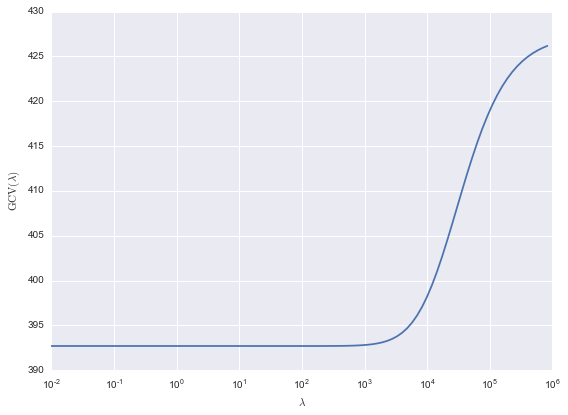

In [612]:
def gcv_score(results):
    X = results.model.exog[:-(q + 2), :]
    n = X.shape[0]
    y = results.model.endog[:n]
    
    y_hat = results.predict(X)
    hat_matrix_trace = results.get_influence().hat_matrix_diag[:n].sum()
    
    return n * np.power(y - y_hat, 2).sum() / np.power(n - hat_matrix_trace, 2)

lambdas = np.logspace(0, 100, 100, base=1.2) * 1e-2

gcv_scores = np.array([gcv_score(fit(y, X, B, lambda_=lambda_)) for lambda_ in lambdas])

print (lambdas)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(lambdas, gcv_scores);

ax.set_xscale('log');
ax.set_xlabel(r'$\lambda$');

ax.set_ylabel(r'$\operatorname{GCV}(\lambda)$');